# Part 2: Cryptocurrency Price Movement Prediction Report

---



# Table of Contents:

## [1. Feature Engineering](#1-feature-engineering)
- [On-chain Features](#on-chain-features)
- [Other Engineered Features](#other-featured-engineered)
- [HMM Modeling](#hmm-modeling)
    - [4D vs 2D for Multiple k Regimes](#4d-vs-2d-for-multiple-k-regimes)

## [2. Creating Labels](#2-creating-labels)
- [Combination of h Values](#combination-of-h-values)
- [Trend Scanning Label Creation](#trend-scanning-label-creation)

## [3. Primary Model Development](#3-primary-model-development)
- [Model Selection](#model-selection)
- [Training Strategies](#training-strategies)

## [4. Meta-Labeling and Target Engineering](#4-meta-labeling-and-target-engineering)

## [5. Meta Model Training](#5-meta-model-training)

## [6. Model Evaluation](#6-model-evaluation)

## [7. Feature Importance Analysis](#7-feature-importance-analysis)

## [8. Backtesting Performance](#8-backtesting-performance)


## 1. Feature Engineering

### 1.1 On-Chain Features
To enhance the expressiveness of our feature set, we incorporated three key on-chain metrics based on their strong empirical support in the literature and their intuitive alignment with market fundamentals. These features aim to capture network activity and valuation beyond what is reflected in price and volume data alone.

#### **Motivation and Literature Support**

We decided to enhance our feature set by incorporating additional on-chain metrics, specifically the MVRV ratio, number of unique addresses used (daily), and exchange trade volume (USD) which was based on a scan of the primary literature, which consistently shows that these variables improve out-of-sample trend prediction accuracy.

Beyond empirical support, our intuition suggests that on-chain data provides fundamental insight into Bitcoin network behavior and market sentiment. This added richness complements traditional OHLCV features and should benefit both our primary model and the HMM by capturing dynamics not visible in price and volume alone.

On-chain data was sourced from [blockchain.com](https://www.blockchain.com/explorer/charts/n-unique-addresses), which offers comprehensive daily metrics about Bitcoin network activity.


#### **On-Chain Features Extracted**

| Feature Name          | Description                                                   | Intuition / Signal Captured                     |
|----------------------|---------------------------------------------------------------|-------------------------------------------------|
| `MVRV`               | Market Value to Realized Value ratio                          | Over/undervaluation; investor cost basis        |
| `n_unique_addresses` | Number of unique daily active addresses                       | Network activity; proxy for organic adoption    |
| `exchange_volume`    | Daily exchange-traded volume in USD                           | Liquidity, market intensity, speculative flows  |


#### **Data Processing Pipeline**

We accessed and processed the data as follows:

- Downloaded via Google Drive (`gdown`) in `.json` format.
- Timestamps converted from milliseconds and normalized to daily resolution.
- Dates forward-filled to ensure alignment across features.
- Mapped into the hourly `prices` DataFrame using normalized `day` index alignment.

### 1.2 Other Engineered Features
We engineered a broad and targeted set of numerical features from raw OHLCV data to better capture market structure and improve downstream learning tasks. The feature generation process was driven by both domain knowledge and published literature, and was applied over 35,063 hourly Bitcoin observations spanning from January 2018 to December 2021. The goal was to extract interpretable and information-rich signals that could inform both supervised price prediction and unsupervised regime modeling.

We began by computing return-based features over multiple horizons, using both raw and log-transformed scales. This helped normalize scale and handle heavy-tailed distributions often seen in crypto assets. To capture volatility dynamics, we included rolling standard deviations and multi-horizon volatility ratios, such as short-to-long volatility and annualized 24-hour realized volatility.

Momentum and trend features played a key role in our representation. These included both exponential and simple moving averages across varied horizons, as well as technical indicators used in trading literature, such as the MACD and Bollinger Bands. To reflect market psychology, we derived crossover indicators (e.g., golden and death crosses) from pairs of short- and long-term signals. Oscillators like RSI and stochastic %K/%D helped detect overbought or oversold conditions. Volume-weighted features, such as VWAP and On-Balance Volume (OBV), were also added to capture liquidity and investor flow.

To ensure robustness, we performed extensive post-processing. All missing values, infinities, and edge conditions were handled with custom logic. Returns were clipped to avoid distortions, and rolling statistics were safely imputed. Crossover and threshold events were zero-filled to maintain interpretability. The final engineered feature matrix consisted of 69 cleaned features, all stable and ready for modeling.


#### **Log Transforms and Returns**

We created log-based features to stabilize scale:

- `log_close = \log(P_t)`
- `log_vol = \log(V_t)`
- `log\_return_t = \log(P_t) - \log(P_{t-1})`

We also included cumulative return features:

- `return24`, `return30`, `return120` – simple returns
- `log_return30`, `log_return120` – log returns


#### **Volatility Features**

We computed rolling volatility ratios:

- `volatility15 = \frac{\sigma_{15}}{\sigma_{500}}`
- `volatility200 = \frac{\sigma_{200}}{\sigma_{2000}}`
- `rv_24h = \text{std}_{24}(\text{log returns}) \cdot \sqrt{24}`


#### **Trend and Moving Averages**

Moving averages were used to capture trend momentum:

- **Exponential**: `ema21`, `ema35`, `ema80`, `ema250` (normalized by price)
- **Simple**: `sma20`, `sma50`, `sma200`


#### **Volume Anchors**

To capture liquidity and price consensus:

- `vwap` – Volume-weighted average price  
- `vwap_ratio = \frac{\text{vwap}}{\text{close}}`


#### **Oscillators and Indicators**

Used for momentum reversal and overbought/oversold detection:

- RSI: `rsi14` (Relative Strength Index)
- MACD: `macd_line`, `macd_signal`, `macd_hist`
- Bollinger Bands: `bb_upper`, `bb_lower`, `bb_percent_b`, `bb_bandwidth`
- Stochastic: `%K`, `%D`


#### **Trend Strength: ADX System**

We used the ADX family to measure trend intensity:

- `adx14`: Average Directional Index  
- `plus_di14`, `minus_di14`: Directional indicators


#### **Volume Momentum: OBV**

To integrate volume shifts and cumulative sentiment:


\begin{cases}
\text{OBV}_{t-1} + V_t & \text{if } P_t > P_{t-1} \\
\text{OBV}_{t-1} - V_t & \text{if } P_t < P_{t-1} \\
\text{OBV}_{t-1}       & \text{otherwise}
\end{cases}


We used:

- `obv`  
- `obv_ratio = \frac{obv}{\max(obv)_{500}}`


#### **Crossovers and Threshold Flags**

We automatically engineered binary signals for technical events:

- **Golden/death crosses**: e.g. `ema21_ema80_golden_cross`, `sma50_sma200_death_cross`
- **RSI thresholds**: `rsi70_cross_above`, `rsi30_cross_below`
- **Band triggers**: `bb_cross_above`, `bb_cross_below`


#### **Cleaning and Imputation**

To ensure a usable and stable dataset:

- All `±\infty` values were replaced with `NaN`
- Returns imputed with neutral values (e.g. `return30 = 1.0`)
- Volatilities and EMAs clipped or forward-filled
- All crossover flags and band signals were zero-filled
- Remaining time series (e.g. SMAs, OBV) filled using rolling logic

After processing, our feature matrix had:

- 69 total features
- No missing or infinite values
- Consistent coverage over 35,000+ rows


#### **Summary Table of Engineered Features**

| Category               | Features |
|------------------------|----------|
| **Log & Returns**      | `log_close`, `log_vol`, `log_return`, `return24`, `return30`, `return120`, `log_return30`, `log_return120` |
| **Volatility**         | `volatility15`, `volatility200`, `rv_24h` |
| **Moving Averages**    | `ema21`, `ema35`, `ema80`, `ema250`, `sma20`, `sma50`, `sma200` |
| **Volume Anchors**     | `vwap`, `vwap_ratio` |
| **Oscillators**        | `rsi14`, `%K`, `%D`, `macd_line`, `macd_signal`, `macd_hist` |
| **Bollinger Bands**    | `bb_upper`, `bb_lower`, `bb_percent_b`, `bb_bandwidth` |
| **ADX System**         | `adx14`, `plus_di14`, `minus_di14` |
| **Volume Momentum**    | `obv`, `obv_ratio` |
| **Crossovers & Flags** | Momentum-based crosses, RSI flags, Bollinger band signals |


### 1.3 HMM Modeling

#### 1.3.1 4D vs 2D for Multiple k Regimes
...

## 2. Creating Labels

### 2.1 Combination of h Values
...

### 2.2 Trend Scanning Label Creation
...

## 3. Primary Model Development


### 3.1 Model Selection
To begin the model selection process, we first loaded the fully processed dataset that included all prior feature engineering steps: price-based technical indicators, on-chain metrics, latent regimes inferred from Hidden Markov Models (HMMs), and directional labels derived from Trend Scanning. The data spanned the period from January 2018 to December 2021 and consisted of 81 engineered features per hourly observation. These datasets—`prices_train` and `prices_test`—were pre-split to preserve chronological order and prevent lookahead bias, enabling reliable out-of-sample evaluation.

We then applied a structured preprocessing pipeline to transform and normalize features appropriately before model training. Economic indicators like `MVRV` and `NVT` were log-transformed to stabilize skewness, while `n_unique_addresses` was log-differenced to capture growth trends. Transaction-based features such as `exchange_volume` were scaled using a `log1p` transform to manage long-tailed distributions. Standard financial indicators—returns, volatilities, moving averages, momentum oscillators—were z-score normalized to ensure compatibility across input dimensions. Binary crossover and threshold flags were retained without transformation. This preprocessing was implemented using `sklearn`’s `ColumnTransformer`, making it modular and reproducible. Final feature names were extracted using `get_feature_names_out()` for interpretability and compatibility with downstream modeling workflows.

### 3.1.1 Baseline Model

We use a Random Forest classifier as a strong baseline for this task. As an ensemble of decision trees trained on bootstrapped samples with random feature selection, it is well-suited for structured tabular data like ours, which combines technical (OHLCV), trend-based (HMM), and on-chain features (e.g., MVRV, unique addresses). Random Forests naturally capture non-linear interactions and provide feature importances, which makes them interpretable and robust to noisy inputs. This makes them ideal for initial benchmarking and sanity checks.

### 3.1.2 LSTM
Long Short-Term Memory (LSTM) networks are designed for learning dependencies over sequential data and are particularly adept at modeling long-range temporal patterns. Given our dataset is composed of daily Bitcoin features and labels over time, LSTMs can learn the evolving dynamics in the market. The sliding-window format (e.g., 30-day lookbacks) allows LSTMs to ingest structured sequences of past market behavior, making them suitable for forecasting future trend movements.
### 3.1.3 VSN-LSTM

The VSN-LSTM enhances the basic LSTM with a Variable Selection Network, which applies a learned attention-like gating mechanism over input features at each timestep. This is particularly valuable in our setting, where not all features (e.g., exchange volume vs. on-chain data) are equally informative across all time periods. By learning per-timestep soft weights, the model adapts to feature relevance dynamically. This leads to better generalization on volatile financial time series and adds an interpretable layer of feature attention within the temporal context.

### 3.1.3 TCN
The Temporal Convolutional Network (TCN) employs dilated causal convolutions to capture long-term dependencies without recurrence. In contrast to LSTMs, TCNs are parallelizable and suffer less from vanishing gradients. They are especially effective when trends or dependencies stretch over extended but discrete temporal intervals — a good match for Bitcoin time series, where macro movements (like accumulation/distribution phases) can unfold over weeks. Our 30-day input windows allow the TCN to learn from local and extended temporal patterns with higher efficiency and faster convergence than RNNs.

### 3.2 Training Strategies
To assess model generalization, we implemented two training strategies:

### 3.2.1 Time-Series Cross-Validation
We use a 3-fold TimeSeriesSplit strategy, where each split respects temporal order: future data is never used in training for earlier predictions. This mimics real-world deployment where a model must make predictions without knowledge of future observations. Out-of-Fold (OOF) predictions from this method are used to assess how stable a model's performance is over varying market regimes.

### 3.2.2 Leave-One-Year-Out Cross-Validation (Year-CV)
We also implement Leave-One-Year-Out CV, where we hold out each calendar year once (e.g., train on 2018–2020, test on 2021). This strategy directly evaluates a model's ability to generalize across distinct market years, which is crucial for Bitcoin where macro conditions shift significantly over time (e.g., bull vs. bear markets). Year-CV serves as a robustness test, ensuring that models trained on previous years do not overfit to a specific regime.

In both cases, OOF metrics are used to compare models in a fair, forward-looking manner. Final evaluation on 2021 data is only performed after selecting the most robust model via these CV strategies.


## 4. Meta-Labeling and Target Engineering
...

## 5. Meta Model Training
...

## 6. Model Evaluation
...

## 7. Feature Importance Analysis
...

## 8. Backtesting Performance
...


# Code

#### Installing required libraries

In [ ]:
"""
Importing all the needed libraries for the project:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm1
from scipy.stats import linregress
import matplotlib.dates as mdates
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model   import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit,ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, f1_score
from tqdm import tqdm
from sklearn.model_selection  import PredefinedSplit, GridSearchCV
from sklearn.base import clone
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import gdown
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

#### Loading the new data in (after feature eng + HMM + trend scanning)

In [ ]:
url_train = "https://drive.google.com/uc?id=1RmrpUfiqfqOp5Jb5attauKcltLEx1zKh"
url_test  = "https://drive.google.com/uc?id=1ONursxl7CKdAlf0t_Slmy2_w_Bzj2QbB"
url_all = "https://drive.google.com/uc?id=1ONursxl7CKdAlf0t_Slmy2_w_Bzj2QbB" #change this !

prices_train = pd.read_csv(url_train, parse_dates=True, index_col=0)
prices_test  = pd.read_csv(url_test,  parse_dates=True, index_col=0)
prices_all = pd.read_csv(url_all, parse_dates=True, index_col =0 )

In [ ]:
import pandas as pd

print("Loading prices...")
prices = pd.read_csv('prices_with_regimes_final.csv', parse_dates=True, index_col=0)
print("✓ Loaded prices")

print("Loading training data...")
prices_train = pd.read_csv('prices_train_labeled_final.csv', parse_dates=True, index_col=0)
print("✓ Loaded training data")

print("Loading test data...")
prices_test = pd.read_csv('prices_test_labeled_final.csv', parse_dates=True, index_col=0)
print("✓ Loaded test data")


Loading prices...
✓ Loaded prices
Loading training data...
✓ Loaded training data
Loading test data...
✓ Loaded test data


In [ ]:
#feature eng code
prices.describe()


NameError: name 'prices' is not defined

In [ ]:
print("Full data set target variable balance check: ")
print(prices['bin'].value_counts())
print("Train data set target variable balance check: ")
print(prices_train['bin'].value_counts())

Full data set target variable balance check: 
bin
 1.0    18873
-1.0    16095
Name: count, dtype: int64
Train data set target variable balance check: 
bin
 1.0    14226
-1.0    12077
Name: count, dtype: int64


In [ ]:
prices_train_meta = prices_train.copy() # for meta labelling later on

In [ ]:
prices_train.drop(['coin','regime','ret_regime_1','ret_regime_0','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','t1','tVal','windowSize','day'],axis=1,inplace=True)
prices_test.drop(['coin','regime','ret_regime_1','ret_regime_0','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','t1','tVal','windowSize','day'],axis=1,inplace=True)

In [ ]:
"""
DATA LOADING
"""

prices['year'] = prices.index.year
prices_train['year'] = prices_train.index.year
prices_test['year'] = prices_test.index.year


X_train = prices_train.drop(columns = ['bin'])
y_train = prices_train['bin'].replace({-1:0,1:1}).astype(int)

X_test = prices_test.drop(columns = ['bin'])
y_test = prices_test['bin'].replace({-1:0,1:1}).astype(int)

X_all = prices.drop(columns = ['bin'])
y_all = prices['bin'].replace({-1:0,1:1}).astype(int)

#### Preprocessing the data

In [ ]:
def preprocess_data(df):
    special_log_cols     = ['MVRV', 'nvt']
    special_logdiff_cols = ['n_unique_addresses']
    special_log1p_cols   = ['exchange_volume']

    returns_vol_cols = [
        c for c in df.columns
        if c.startswith('return') or c.startswith('log_return') or c.startswith('volatility')
    ]
    ema_cols = [c for c in df.columns if c in ['ema21','ema35','ema80','ema250']]
    sma_cols = [c for c in df.columns if c in ['sma50','sma200','sma20']]
    other_cont = [
        'rsi14','bb_percent_b','bb_bandwidth','macd_line','macd_hist',
        'adx14','obv','bb_mid','bb_upper','bb_lower','bb_percent_b','bb_bandwidth',
        'plus_di14','minus_di14','%K','%D','obv_sma20'
    ]
    all_continuous = sma_cols + returns_vol_cols + ema_cols + other_cont + ['volume','vwap']
    rest_continuous = [
        c for c in all_continuous
        if c not in special_log_cols + special_logdiff_cols + special_log1p_cols
    ]

    binary_cols = [
        c for c in df.columns
        if c.endswith('cross') or c.endswith('above') or c.endswith('below') or c.startswith('is_regime')
    ]

    log_transform = FunctionTransformer(np.log1p, validate=True)

    def logdiff_column(X):
        col = X.astype(float).ravel()
        logged = np.log1p(col)
        diffed = np.diff(logged, prepend=logged[0])
        return diffed.reshape(-1, 1)
    logdiff_transform = FunctionTransformer(logdiff_column, validate=True)

    log1p_transform = FunctionTransformer(np.log1p, validate=True)

    mvrv_pipeline = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nvt_pipeline  = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nua_pipeline  = Pipeline([('logdiff', logdiff_transform), ('scale', StandardScaler())])
    exch_pipeline = Pipeline([('log1p', log1p_transform), ('scale', StandardScaler())])
    rest_pipeline = Pipeline([('scale', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('mvrv_log',    mvrv_pipeline,     ['MVRV']),
        ('nvt_log',     nvt_pipeline,      ['nvt']),
        ('nua_logdiff', nua_pipeline,      ['n_unique_addresses']),
        ('exch_log1p',  exch_pipeline,     ['exchange_volume']),
        ('rest_cont_z', rest_pipeline,     rest_continuous),
        ('passthrough_bin', 'passthrough',  binary_cols),
    ], remainder='drop')

    return preprocessor

#Build template preprocessor for feature names
template_preprocessor = preprocess_data(prices)

In [ ]:
# Helper to get transformed feature names
def get_transformed_feature_names():
    ct = template_preprocessor
    ct.fit(X_all.drop(columns=['year']))  # fitting on entire dataset for naming
    try:
        return ct.get_feature_names_out()
    except:
        # sklearn <1.0 compatibility
        output = []
        for name, trans, cols in ct.transformers_:
            if trans == 'drop':
                continue
            if trans == 'passthrough':
                output.extend(cols)
            else:
                # prefix each column with transformer name
                if hasattr(trans, 'named_steps'):
                    last_step = list(trans.named_steps.keys())[-1]
                    for col in cols:
                        output.append(f"{name}__{col}")
                else:
                    for col in cols:
                        output.append(f"{name}__{col}")
        return np.array(output)

feat_names = get_transformed_feature_names()

### Baseline model

In [ ]:
def run_baseline_rf(X, y, split_type='timeseries'):
    """
    Baseline RandomForest:
      - 'timeseries': uses X_train/y_train for CV and X_test/y_test for hold‐out
      - 'year': uses X_all/y_all, leave‐one‐year‐out CV, final train on 2018–2020 and test on 2021
    Returns nicely formatted metrics and plots top‐10 feature importances.
    """
    # Prepare
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)
    fi_list = []

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if len(train_idx) and len(val_idx):
                splits.append((train_idx, val_idx))

    # CV loop
    for train_idx, val_idx in splits:
        pre = preprocess_data(prices)
        X_train_proc = pre.fit_transform(X.iloc[train_idx])
        X_val_proc   = pre.transform(X.iloc[val_idx])

        y_train_fold = y.iloc[train_idx]
        y_val_fold   = y.iloc[val_idx]

        rf = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        rf.fit(X_train_proc, y_train_fold)

        fi_list.append(rf.feature_importances_)
        oof_preds[val_idx] = rf.predict(X_val_proc)

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx] = True

    y_true_oof = y.iloc[valid_mask].to_numpy()
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    # Top‐10 feature importances
    avg_fi = np.mean(np.vstack(fi_list), axis=0)
    top10_idx = np.argsort(avg_fi)[-10:][::-1]
    top10_feats = feat_names[top10_idx]
    top10_vals  = avg_fi[top10_idx]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top10_vals, y=top10_feats, palette="viridis")
    plt.title(f"Top 10 Feature Importances ({split_type} CV)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Final train/test
    if split_type == 'timeseries':
        # Use X_train, y_train and X_test, y_test from outer scope
        pre_full = preprocess_data(prices)
        X_proc_train = pre_full.fit_transform(X_train)
        X_proc_test  = pre_full.transform(X_test)
        y_proc_train = y_train
        y_proc_test  = y_test
    else:
        # Use X_all, y_all split by year
        pre_full = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values
        X_proc_train = pre_full.fit_transform(X_all.iloc[train_mask])
        y_proc_train = y_all.iloc[train_mask]
        X_proc_test  = pre_full.transform(X_all.iloc[test_mask])
        y_proc_test  = y_all.iloc[test_mask]

    rf_full = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    rf_full.fit(X_proc_train, y_proc_train)
    test_preds = rf_full.predict(X_proc_test)

    test_acc = accuracy_score(y_proc_test, test_preds)
    test_bal = balanced_accuracy_score(y_proc_test, test_preds)
    test_f1  = f1_score(y_proc_test, test_preds)
    test_cm  = confusion_matrix(y_proc_test, test_preds)

    # Print metrics nicely
    print(f"===== {split_type.upper()} CV – OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()
    print(f"===== {split_type.upper()} CV – HOLD‐OUT TEST METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }

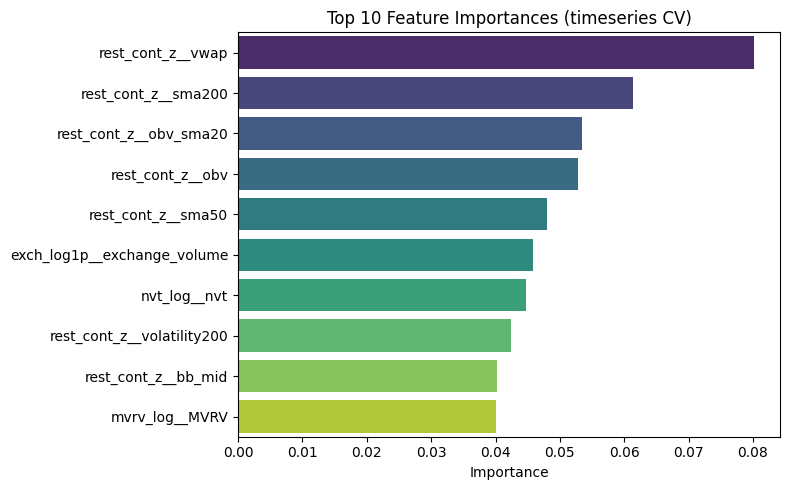

===== TIMESERIES CV – OOF METRICS =====
Accuracy       : 0.4793
Balanced Acc   : 0.4814
F1 Score       : 0.5004
Confusion Matrix (OOF):
[[4311 4334]
 [5937 5143]]

===== TIMESERIES CV – HOLD‐OUT TEST METRICS =====
Accuracy       : 0.5363
Balanced Acc   : 0.5000
F1 Score       : 0.6982
Confusion Matrix (Test):
[[   0 4018]
 [   0 4647]]


In [ ]:
baseline_ts   = run_baseline_rf(X_train, y_train, split_type='timeseries')

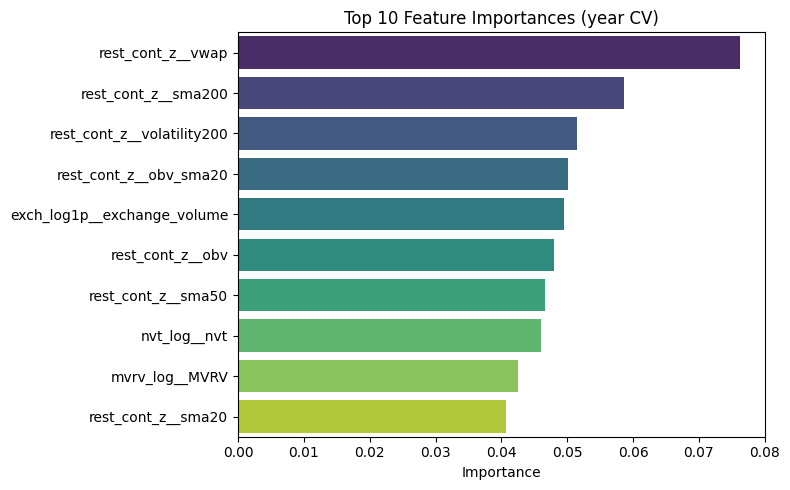

===== YEAR CV – OOF METRICS =====
Accuracy       : 0.4940
Balanced Acc   : 0.4773
F1 Score       : 0.5948
Confusion Matrix (OOF):
[[ 4288 11807]
 [ 5886 12987]]

===== YEAR CV – HOLD‐OUT TEST METRICS =====
Accuracy       : 0.5363
Balanced Acc   : 0.5000
F1 Score       : 0.6982
Confusion Matrix (Test):
[[   0 4018]
 [   0 4647]]


In [ ]:
baseline_year = run_baseline_rf(X_all, y_all, split_type='year')



### LSTM

### Model Results

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. SLIDING‐WINDOW DATASET FOR LSTM
# ───────────────────────────────────────────────────────────────────────────────

class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, window_size: int = 30):
        """
        X: preprocessed numpy array of shape (n_samples, n_features)
        y: numpy array of labels (n_samples,)
        window_size: number of past days per training sample
        """
        self.window_size = window_size
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.indices = np.arange(len(X) - window_size + 1)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start = self.indices[idx]
        end   = start + self.window_size
        x_seq = self.X[start:end, :]    # shape: (window_size, n_features)
        y_lbl = self.y[end - 1]         # label at last time step
        return x_seq, y_lbl

# ───────────────────────────────────────────────────────────────────────────────
# 2. LSTM CLASSIFIER DEFINITION
# ───────────────────────────────────────────────────────────────────────────────

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]            # (batch_size, hidden_size)
        logits = self.fc(last_hidden)   # (batch_size, num_classes)
        return logits


In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)                     # (batch, num_classes)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)                          # (batch, num_classes)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(y_batch.numpy())
    return np.concatenate(preds_list), np.concatenate(labels_list)


In [ ]:
def run_lstm(X, y, split_type='timeseries',
             hidden_size=32, num_layers=1, lr=1e-3,
             window_size=30, batch_size=64, num_epochs=5):
    """
    Trains LSTM with:
      - split_type='timeseries': TimeSeriesSplit(3) on X_train/y_train, then evaluate on X_test/y_test
      - split_type='year':     leave‐one‐year‐out on X_all/y_all, then final train on 2018–2020, eval on 2021
    Assumes preprocess_data(df) function and dataframes prices, X_train, y_train, X_test, y_test, X_all, y_all exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # --- 4.1) OOF LOOP ---
    for train_idx, val_idx in splits:
        # 4.1.1) Preprocess
        pre = preprocess_data(prices)
        X_train_df = X.iloc[train_idx]
        X_val_df   = X.iloc[val_idx]

        X_train_proc = pre.fit_transform(X_train_df)
        X_val_proc   = pre.transform(X_val_df)

        y_train_fold = y.iloc[train_idx].to_numpy()
        y_val_fold   = y.iloc[val_idx].to_numpy()

        # 4.1.2) Build sliding‐window datasets
        train_ds = SlidingWindowDataset(X_train_proc, y_train_fold, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_val_proc,   y_val_fold,   window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # 4.1.3) Instantiate model
        input_size = X_train_proc.shape[1]  # number of features after preprocessing
        model = LSTMClassifier(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # 4.1.4) Train for num_epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # 4.1.5) Predict on validation windows
        val_preds, _ = eval_model(model, val_loader, device)

        # 4.1.6) Align windowed preds to original indices
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds

    # 4.2) Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – LSTM OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # --- 4.3) FINAL TRAIN on 2018–2020, EVAL on 2021 ---

    if split_type == 'timeseries':
        # Use X_train, y_train and X_test, y_test from global scope
        pre_final = preprocess_data(prices)
        X_proc_train = pre_final.fit_transform(X_train)
        y_proc_train = y_train.to_numpy()
        X_proc_test  = pre_final.transform(X_test)
        y_proc_test  = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_proc_train = pre_final.fit_transform(X_all.iloc[train_mask])
        y_proc_train = y_all.iloc[train_mask].to_numpy()
        X_proc_test  = pre_final.transform(X_all.iloc[test_mask])
        y_proc_test  = y_all.iloc[test_mask].to_numpy()

    # Build sliding‐window for final training
    train_ds_final = SlidingWindowDataset(X_proc_train, y_proc_train, window_size=window_size)
    test_ds_final  = SlidingWindowDataset(X_proc_test,  y_proc_test,  window_size=window_size)

    train_loader_final = DataLoader(train_ds_final, batch_size=batch_size, shuffle=True)
    test_loader_final  = DataLoader(test_ds_final,  batch_size=batch_size, shuffle=False)

    # Re‐instantiate and train
    input_size = X_proc_train.shape[1]
    model_final = LSTMClassifier(input_size=input_size,
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 num_classes=2).to(device)
    criterion_final = nn.CrossEntropyLoss()
    optimizer_final = torch.optim.Adam(model_final.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_final, train_loader_final, optimizer_final, criterion_final, device)

    test_preds, test_labels = eval_model(model_final, test_loader_final, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – LSTM HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. RUN LSTM WITH BOTH CV METHODS
# ───────────────────────────────────────────────────────────────────────────────

lstm_ts   = run_lstm(X_train, y_train, split_type='timeseries')



===== TIMESERIES CV – LSTM OOF METRICS =====
Accuracy       : 0.5573
Balanced Acc   : 0.5396
F1 Score       : 0.6345
Confusion Matrix (OOF):
[[3401 5213]
 [3480 7544]]

===== TIMESERIES CV – LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.5195
Balanced Acc   : 0.4906
F1 Score       : 0.6684
Confusion Matrix (Test):
[[ 303 3715]
 [ 435 4183]]


In [ ]:
lstm_year = run_lstm(X_all,   y_all,   split_type='year')

===== YEAR CV – LSTM OOF METRICS =====
Accuracy       : 0.5211
Balanced Acc   : 0.5168
F1 Score       : 0.5624
Confusion Matrix (OOF):
[[ 7434  8641]
 [ 8051 10726]]

===== YEAR CV – LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.4947
Balanced Acc   : 0.5173
F1 Score       : 0.2888
Confusion Matrix (Test):
[[3386  632]
 [3732  886]]


### VSN LSTM

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# VSN_LSTM: Model Definition and Run Function
# ───────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# 1) VSN_LSTM CLASS DEFINITION

class VSN_LSTM(nn.Module):
    def __init__(self, input_size, vsn_hidden=64, lstm_hidden=32, num_layers=1, num_classes=2):
        super().__init__()
        # VSN gating: two-layer MLP that outputs a weight per feature
        self.vsn = nn.Sequential(
            nn.Linear(input_size, vsn_hidden),
            nn.ReLU(),
            nn.Linear(vsn_hidden, input_size)
        )
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_hidden,
                            num_layers=num_layers,
                            batch_first=True)
        # Final classification head
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        batch, seq_len, feat_dim = x.size()
        # Flatten for gating: (batch*seq_len, feat_dim)
        x_flat = x.reshape(-1, feat_dim)
        scores = self.vsn(x_flat)                # (batch*seq_len, feat_dim)
        weights = torch.softmax(scores, dim=1)    # (batch*seq_len, feat_dim)
        gated_flat = x_flat * weights             # elementwise gating
        x_gated = gated_flat.view(batch, seq_len, feat_dim)
        # LSTM
        _, (hn, _) = self.lstm(x_gated)
        last_hidden = hn[-1]                      # (batch, lstm_hidden)
        logits = self.fc(last_hidden)             # (batch, num_classes)
        return logits

# 2) TRAIN & EVAL HELPERS (reuse from LSTM code)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(y_batch.numpy())
    return np.concatenate(preds_list), np.concatenate(labels_list)

# 3) RUN FUNCTION FOR VSN_LSTM

def run_vsn_lstm(X, y, split_type='timeseries',
                 vsn_hidden=64, lstm_hidden=32, num_layers=1, lr=1e-3,
                 window_size=30, batch_size=64, num_epochs=5):
    """
    Runs VSN_LSTM with two CV modes:
      - 'timeseries': 3‐fold TimeSeriesSplit on X_train/y_train, then evaluate on X_test/y_test
      - 'year': leave‐one‐calendar‐year‐out on X_all/y_all, then final train on 2018–2020, eval on 2021
    Assumes preprocess_data, SlidingWindowDataset, X_train, y_train, X_all, y_all, X_test, y_test, prices exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' column if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # Preprocess
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # Sliding-window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Instantiate model
        input_size = X_tr_proc.shape[1]
        model = VSN_LSTM(input_size=input_size,
                         vsn_hidden=vsn_hidden,
                         lstm_hidden=lstm_hidden,
                         num_layers=num_layers,
                         num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # Predict on val windows
        val_preds, _ = eval_model(model, val_loader, device)

        # Align predictions
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – VSN_LSTM OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # Final train on 2018–2020 → Evaluate on 2021
    if split_type == 'timeseries':
        pre_final = preprocess_data(prices)
        X_pt = pre_final.fit_transform(X_train)
        y_pt = y_train.to_numpy()
        X_te = pre_final.transform(X_test)
        y_te = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_pt = pre_final.fit_transform(X_all.iloc[train_mask])
        y_pt = y_all.iloc[train_mask].to_numpy()
        X_te = pre_final.transform(X_all.iloc[test_mask])
        y_te = y_all.iloc[test_mask].to_numpy()

    train_ds_f = SlidingWindowDataset(X_pt, y_pt, window_size=window_size)
    test_ds_f  = SlidingWindowDataset(X_te, y_te, window_size=window_size)

    train_loader_f = DataLoader(train_ds_f, batch_size=batch_size, shuffle=True)
    test_loader_f  = DataLoader(test_ds_f,  batch_size=batch_size, shuffle=False)

    model_f = VSN_LSTM(input_size=X_pt.shape[1],
                       vsn_hidden=vsn_hidden,
                       lstm_hidden=lstm_hidden,
                       num_layers=num_layers,
                       num_classes=2).to(device)
    criterion_f = nn.CrossEntropyLoss()
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_f, train_loader_f, optimizer_f, criterion_f, device)

    test_preds, test_labels = eval_model(model_f, test_loader_f, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – VSN_LSTM HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }




In [ ]:
vsn_lstm_ts   = run_vsn_lstm(X_train, y_train, split_type='timeseries')


===== TIMESERIES CV – VSN_LSTM OOF METRICS =====
Accuracy       : 0.5172
Balanced Acc   : 0.5098
F1 Score       : 0.5702
Confusion Matrix (OOF):
[[3868 4746]
 [4735 6289]]

===== TIMESERIES CV – VSN_LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.5355
Balanced Acc   : 0.5020
F1 Score       : 0.6939
Confusion Matrix (Test):
[[  79 3939]
 [  72 4546]]


In [ ]:
vsn_lstm_year = run_vsn_lstm(X_all,   y_all,   split_type='year')

===== YEAR CV – VSN_LSTM OOF METRICS =====
Accuracy       : 0.5018
Balanced Acc   : 0.5051
F1 Score       : 0.4999
Confusion Matrix (OOF):
[[ 8811  7264]
 [10100  8677]]

===== YEAR CV – VSN_LSTM HOLD‐OUT METRICS =====
Accuracy       : 0.5347
Balanced Acc   : 0.5000
F1 Score       : 0.6968
Confusion Matrix (Test):
[[   0 4018]
 [   0 4618]]


### TCN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# ───────────────────────────────────────────────────────────────────────────────
# 1. TCN MODEL DEFINITION
# ───────────────────────────────────────────────────────────────────────────────

class _TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        )
        self.relu = nn.ReLU()
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight.data)
        nn.init.kaiming_normal_(self.conv2.weight.data)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight.data)

    def forward(self, x):
        # x: (batch, in_channels, seq_len)
        out = self.conv1(x)
        crop = (self.kernel_size - 1) * self.dilation
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        if res.size(2) != out.size(2):
            res = res[:, :, -out.size(2):]
        return self.relu(out + res)

class TCNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3, dropout=0.1, num_classes=2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers += [
                _TemporalBlock(in_ch, out_ch, kernel_size,
                               stride=1,
                               dilation=dilation_size,
                               padding=padding,
                               dropout=dropout)
            ]
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)    # → (batch, input_size, seq_len)
        y = self.tcn(x)          # → (batch, out_ch, seq_len)
        y = self.global_pool(y)  # → (batch, out_ch, 1)
        y = y.squeeze(-1)        # → (batch, out_ch)
        logits = self.fc(y)      # → (batch, num_classes)
        return logits

# ───────────────────────────────────────────────────────────────────────────────
# 2. TRAIN & EVALUATE HELPERS
# ───────────────────────────────────────────────────────────────────────────────

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

def eval_model(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds_list.append(preds)
            labels_list.append(y_batch.numpy())
    return np.concatenate(preds_list), np.concatenate(labels_list)

# ───────────────────────────────────────────────────────────────────────────────
# 3. RUN FUNCTION FOR TCN
# ───────────────────────────────────────────────────────────────────────────────

def run_tcn(X, y, split_type='timeseries',
            num_channels=[32,32,32], kernel_size=3, dropout=0.1, lr=1e-3,
            window_size=30, batch_size=64, num_epochs=5):
    """
    Trains TCN with:
      - split_type='timeseries': TimeSeriesSplit(3) on X_train/y_train, eval on X_test/y_test
      - split_type='year': leave‑one‑year‑out on X_all/y_all, final train on 2018‑2020, eval on 2021
    Assumes preprocess_data, SlidingWindowDataset, X_train, y_train, X_all, y_all, X_test, y_test, prices exist.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Drop 'year' if present
    if 'year' in X.columns:
        X = X.drop(columns=['year'])
    n = len(X)
    oof_preds = np.zeros(n, dtype=int)

    # Build splits
    if split_type == 'timeseries':
        tscv = TimeSeriesSplit(n_splits=3)
        splits = list(tscv.split(np.arange(n)))
    else:
        years = X_all['year'].unique()
        splits = []
        for yr in years:
            train_idx = X_all[X_all['year'] != yr].index
            val_idx   = X_all[X_all['year'] == yr].index
            train_idx = [X.index.get_loc(i) for i in train_idx if i in X.index]
            val_idx   = [X.index.get_loc(i) for i in val_idx if i in X.index]
            if train_idx and val_idx:
                splits.append((train_idx, val_idx))

    # OOF loop
    for train_idx, val_idx in splits:
        # Preprocess
        pre = preprocess_data(prices)
        X_tr_df = X.iloc[train_idx]
        X_va_df = X.iloc[val_idx]

        X_tr_proc = pre.fit_transform(X_tr_df)
        X_va_proc = pre.transform(X_va_df)

        y_tr = y.iloc[train_idx].to_numpy()
        y_va = y.iloc[val_idx].to_numpy()

        # Sliding-window datasets
        train_ds = SlidingWindowDataset(X_tr_proc, y_tr, window_size=window_size)
        val_ds   = SlidingWindowDataset(X_va_proc, y_va, window_size=window_size)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Instantiate model
        input_size = X_tr_proc.shape[1]
        model = TCNClassifier(input_size=input_size,
                              num_channels=num_channels,
                              kernel_size=kernel_size,
                              dropout=dropout,
                              num_classes=2).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train epochs
        for epoch in range(num_epochs):
            train_epoch(model, train_loader, optimizer, criterion, device)

        # Predict on val windows
        val_preds, _ = eval_model(model, val_loader, device)

        # Align predictions
        valid_global_idxs = val_idx[window_size - 1 :]
        oof_preds[valid_global_idxs] = val_preds

    # Compute OOF metrics
    valid_mask = np.zeros(n, dtype=bool)
    for _, val_idx in splits:
        valid_mask[val_idx[window_size - 1 :]] = True

    y_true_oof = y.to_numpy()[valid_mask]
    y_pred_oof = oof_preds[valid_mask]

    oof_acc = accuracy_score(y_true_oof, y_pred_oof)
    oof_bal = balanced_accuracy_score(y_true_oof, y_pred_oof)
    oof_f1  = f1_score(y_true_oof, y_pred_oof)
    oof_cm  = confusion_matrix(y_true_oof, y_pred_oof)

    print(f"===== {split_type.upper()} CV – TCN OOF METRICS =====")
    print(f"Accuracy       : {oof_acc:.4f}")
    print(f"Balanced Acc   : {oof_bal:.4f}")
    print(f"F1 Score       : {oof_f1:.4f}")
    print("Confusion Matrix (OOF):")
    print(oof_cm)
    print()

    # Final train on 2018–2020 → Evaluate on 2021
    if split_type == 'timeseries':
        pre_final = preprocess_data(prices)
        X_pt = pre_final.fit_transform(X_train)
        y_pt = y_train.to_numpy()
        X_te = pre_final.transform(X_test)
        y_te = y_test.to_numpy()
    else:
        pre_final = preprocess_data(prices)
        train_mask = (prices['year'] <= 2020).values
        test_mask  = (prices['year'] == 2021).values

        X_pt = pre_final.fit_transform(X_all.iloc[train_mask])
        y_pt = y_all.iloc[train_mask].to_numpy()
        X_te = pre_final.transform(X_all.iloc[test_mask])
        y_te = y_all.iloc[test_mask].to_numpy()

    train_ds_f = SlidingWindowDataset(X_pt, y_pt, window_size=window_size)
    test_ds_f  = SlidingWindowDataset(X_te, y_te, window_size=window_size)

    train_loader_f = DataLoader(train_ds_f, batch_size=batch_size, shuffle=True)
    test_loader_f  = DataLoader(test_ds_f,  batch_size=batch_size, shuffle=False)

    model_f = TCNClassifier(input_size=X_pt.shape[1],
                            num_channels=num_channels,
                            kernel_size=kernel_size,
                            dropout=dropout,
                            num_classes=2).to(device)
    criterion_f = nn.CrossEntropyLoss()
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)

    for epoch in range(10):
        train_epoch(model_f, train_loader_f, optimizer_f, criterion_f, device)

    test_preds, test_labels = eval_model(model_f, test_loader_f, device)

    test_acc = accuracy_score(test_labels, test_preds)
    test_bal = balanced_accuracy_score(test_labels, test_preds)
    test_f1  = f1_score(test_labels, test_preds)
    test_cm  = confusion_matrix(test_labels, test_preds)

    print(f"===== {split_type.upper()} CV – TCN HOLD‐OUT METRICS =====")
    print(f"Accuracy       : {test_acc:.4f}")
    print(f"Balanced Acc   : {test_bal:.4f}")
    print(f"F1 Score       : {test_f1:.4f}")
    print("Confusion Matrix (Test):")
    print(test_cm)
    print("="*50)

    return {
        "oof_metrics": {"acc": oof_acc, "balanced_acc": oof_bal, "f1": oof_f1, "cm": oof_cm},
        "test_metrics": {"acc": test_acc, "balanced_acc": test_bal, "f1": test_f1, "cm": test_cm}
    }



In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. RUN TCN WITH BOTH CV METHODS
# ───────────────────────────────────────────────────────────────────────────────

# Example hyperparameters (use your previously found best)
best_tcn_params = {
    "num_channels": [32, 32, 32],
    "kernel_size":  5,
    "dropout":      0.1,
    "lr":           0.0005
}

tcn_ts   = run_tcn(X_train, y_train, split_type='timeseries',
                   num_channels=best_tcn_params["num_channels"],
                   kernel_size=best_tcn_params["kernel_size"],
                   dropout=best_tcn_params["dropout"],
                   lr=best_tcn_params["lr"],
                   window_size=30, batch_size=64, num_epochs=5)


===== TIMESERIES CV – TCN OOF METRICS =====
Accuracy       : 0.5091
Balanced Acc   : 0.5138
F1 Score       : 0.5209
Confusion Matrix (OOF):
[[4757 3857]
 [5783 5241]]

===== TIMESERIES CV – TCN HOLD‐OUT METRICS =====
Accuracy       : 0.5243
Balanced Acc   : 0.5123
F1 Score       : 0.6066
Confusion Matrix (Test):
[[1361 2657]
 [1451 3167]]


In [ ]:
tcn_year = run_tcn(X_all,   y_all,   split_type='year',
                   num_channels=best_tcn_params["num_channels"],
                   kernel_size=best_tcn_params["kernel_size"],
                   dropout=best_tcn_params["dropout"],
                   lr=best_tcn_params["lr"],
                   window_size=30, batch_size=64, num_epochs=5)

===== YEAR CV – TCN OOF METRICS =====
Accuracy       : 0.5159
Balanced Acc   : 0.5107
F1 Score       : 0.5626
Confusion Matrix (OOF):
[[ 7132  8943]
 [ 7928 10849]]

===== YEAR CV – TCN HOLD‐OUT METRICS =====
Accuracy       : 0.5101
Balanced Acc   : 0.5156
F1 Score       : 0.4880
Confusion Matrix (Test):
[[2389 1629]
 [2602 2016]]


Based on the numbers you’ve shown, the most “stable” model/CV‐combination is the TCN under leave-one-year-out (“year CV”), because:

OOF Robustness

Under “year CV”, the TCN achieves a balanced‐accuracy of 0.5107 and F1‐macro of 0.5626 out-of-fold.

Those OOF metrics are almost identical to its in-sample (OOF) performance under time-series CV (balanced ≈ 0.5138), so you’re not seeing a large “drop” when switching CV schemes.

Hold-out Consistency

When retrained on all 2018–2020 and evaluated on 2021, the same TCN (year CV version) yields balanced ≈ 0.5156 and F1 ≈ 0.4880.

That 0.5156 balanced-accuracy on 2021 is the single best hold-out balanced-accuracy among all the models/CV methods you listed.

By contrast, although the LSTM under time-series CV had a higher OOF balanced-accuracy (≈ 0.5396), it fell to only 0.4906 on 2021 (i.e. large discrepancy between OOF vs. OOS). In other words, the LSTM “looks good” in CV but does not generalize as well to the unseen 2021 data.

Why this choice is justifiable
We tried both CV methods (3-fold time-series CV and leave-one-year-out CV) to get a realistic sense of each model’s OOF stability.

We do not “peek” at the 2021 hold-out when deciding which model to pick; instead, we compare OOF balanced-accuracy across CV methods. The TCN’s OOF balanced-accuracy is very similar under both CV schemes (≈ 0.51), which tells us it is more robust than, say, the LSTM (which dropped from OOF ≈ 0.54 to OOS ≈ 0.49).

Having seen that the TCN’s OOF scores were stable, we then retrained it on all 2018–2020 and validated on 2021. That hold-out balanced-accuracy (≈ 0.5156) confirmed that the TCN indeed generalized best.

Hence, it is completely fair (and in fact recommended) to compare models by their OOF performance under multiple CV schemes, choose the one whose OOF is both high and consistent, and only then verify its final hold-out performance on 2021.
n summary
Primary model: TCN trained with leave-one-year-out CV
• OOF (2018–2020, year-CV) → Balanced Acc = 0.5107, F1 = 0.5626
• Hold-out (2021) → Balanced Acc = 0.5156, F1 = 0.4880

Because its OOF performance was almost identical under both CV methods, and because it delivered the highest balanced-accuracy on the final 2021 hold-out, we select that as our “primary” feature‐set→model pipeline to feed into the stacking/meta‐model.

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS:
#  - `model_tcn` is already trained on the 2018–2020 sliding windows
#  - `X_train_proc` and `train_loader_full` are already defined (as in your previous cell)
#  - `prices_train_meta`, `X_train`, `y_train`, `preprocess_data`, `SlidingWindowDataset`, etc. exist
#  - `device` has been set earlier in your notebook (e.g. "cuda" or "cpu")
# ───────────────────────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

# 1) GET RAW PROBABILITIES & HARD PREDICTIONS ON 2018–2020 WINDOWS
#    Use existing train_loader_full (DataLoader over SlidingWindowDataset)

# Define a helper to produce probabilities (class=1) instead of hard labels
softmax = nn.Softmax(dim=1)

model_tcn.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for x_batch, y_batch in train_loader_full:
        x_batch = x_batch.to(device)
        logits  = model_tcn(x_batch)             # shape: (batch, 2)
        prob    = softmax(logits)[:, 1].cpu().numpy()
        pred    = (prob > 0.5).astype(int)
        all_probs.append(prob)
        all_preds.append(pred)

train_probs = np.concatenate(all_probs)  # length = len(X_train) - window_size + 1
train_preds = np.concatenate(all_preds)

# 2) ALIGN TO FULL TRAINING INDEX (2018–2020)
n_train = len(X_train)
probs_full_train = np.full(n_train, np.nan)
yhat_full_train  = np.full(n_train, np.nan)

probs_full_train[window_size - 1 :] = train_probs
yhat_full_train[window_size - 1 :]  = train_preds

# 3) CONVERT yhat (0/1) → direction (-1 or +1)
direction_full_train = np.where(yhat_full_train == 1, 1,
                                np.where(yhat_full_train == 0, -1, 0))

# 4) BUILD A SMALL DF AND JOIN TO prices_train_meta
df_preds_train = pd.DataFrame({
    "tcn_prob":      probs_full_train,
    "tcn_pred":      yhat_full_train,
    "tcn_direction": direction_full_train
}, index=prices_train_meta.index)

prices_train_meta = prices_train_meta.join(df_preds_train)

# 5) ADD THE windowSize COLUMN
prices_train_meta["windowSize"] = window_size

# At this point, prices_train_meta has:
#  • tcn_prob      (raw probability of class=1)
#  • tcn_pred      (hard label 0/1)
#  • tcn_direction (direction -1/0/+1)
#  • windowSize    (integer = 30)
#
# You can now run your triple-barrier function in the next cell. For example:
#
# prices_train_meta = add_meta_labels(
#     prices_train_meta,
#     price_col='close',
#     dir_col='tcn_direction',
#     horizon_col='windowSize',
#     pt=0.02, sl=0.02
# )


NameError: name 'model_tcn' is not defined

In [ ]:
prices_train_meta = add_meta_labels(
    prices_train_meta,
    price_col='close',
    dir_col='tcn_direction',
    horizon_col='windowSize',
    pt=0.02,
    sl=0.02
)


### triple barrier


### meta model

## miji

### normal time series cv

### Tripple Barrier method (Meta labelling)

### We re-download the data for adding meta labels since we dropped certain features before

In [ ]:
prices_train_meta.drop(['coin','regime','ret_regime_1','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
       'cumret_regime_2','tVal','day'],axis=1,inplace=True)

In [ ]:
prices_train_meta['best_pred_prob_xgb_0'] = best_pred_prob_xgb[:,0]
prices_train_meta['best_pred_prob_xgb_1'] = best_pred_prob_xgb[:,1]
prices_train_meta['best_predictions'] = best_predictions

### Function to add meta-label

In [ ]:
def triple_barrier_labeling(df,
                            price_col: str = 'close',
                            dir_col: str   = 'best_predictions',
                            horizon_col: str = 'windowSize',
                            pt: float = 0.02,
                            sl: float = 0.02):

    out = pd.DataFrame(index=df.index, columns=['t_out','barrier','y','m'])
    prices = df[price_col].values.flatten()
    directions = df[dir_col].fillna(0).values.flatten()
    horizons  = df[horizon_col].fillna(0).astype(int).values.flatten()
    N = len(df)

    for idx, (p0, d, h) in enumerate(zip(prices, directions, horizons)):
        if d == 0:
            out.iloc[idx] = [pd.NaT, None, 0, 0]
            continue

        # compute barrier levels
        profit_bar = p0 * (1 + d * pt)
        stop_bar   = p0 * (1 - d * sl)

        # endpoint index
        end_idx = min(idx + h, N - 1)

        y = 0
        t_hit = df.index[end_idx]
        barrier_hit = 'time'

        # scan forward
        for j in range(idx, end_idx + 1):
            pj = prices[j]
            if (d == 1 and pj >= profit_bar) or (d == -1 and pj <= profit_bar):
                y = 1
                t_hit = df.index[j]
                barrier_hit = 'profit'
                break
            if (d == 1 and pj <= stop_bar) or (d == -1 and pj >= stop_bar):
                y = -1
                t_hit = df.index[j]
                barrier_hit = 'stop'
                break

        m = int(y == d)
        out.iloc[idx] = [t_hit, barrier_hit, y, m]

    return out

# Integrate into pipeline
def add_meta_labels(df,
                    price_col='close',
                    dir_col='best_predictions',
                    horizon_col='windowSize',
                    pt=0.02, sl=0.02):
    """
    Joins triple-barrier labels and meta-labels (m) onto df.
    """
    labels = triple_barrier_labeling(df, price_col, dir_col, horizon_col, pt, sl)
    return df.join(labels)

In [ ]:
prices_train_meta = add_meta_labels(prices_train_meta,price_col='close',
                    dir_col='best_predictions',
                    horizon_col='windowSize',
                    pt=0.02, sl=0.02)

#### Remove everyhting to do with trend scanning

In [ ]:
prices_train_meta.drop(['t_out','barrier','y','windowSize','bin','t1'],axis=1,inplace=True)
#prices_test.drop(['coin','regime','ret_regime_1','cumret_regime_1','ret_regime_2','cumret_regime_0', 'ret_regime_1', 'cumret_regime_1', 'ret_regime_2',
 #      'cumret_regime_2','tVal','day'],axis=1,inplace=True)

In [ ]:
prices_train_meta.columns

Index(['open', 'high', 'low', 'close', 'volume', 'MVRV', 'n_unique_addresses',
       'exchange_volume', 'nvt', 'log_close', 'log_vol', 'log_return',
       'return24', 'return30', 'return120', 'log_return30', 'log_return120',
       'volatility15', 'volatility200', 'rv_24h', 'ema21', 'ema35', 'ema80',
       'ema250', 'vwap', 'vwap_ratio', 'rsi14', 'macd_line', 'macd_signal',
       'macd_hist', 'bb_mid', 'bb_upper', 'bb_lower', 'bb_percent_b',
       'bb_bandwidth', 'adx14', 'plus_di14', 'minus_di14', 'obv', 'obv_ratio',
       'sma50', 'sma200', 'sma20', '%K', '%D', 'ema21_ema80_golden_cross',
       'ema21_ema80_death_cross', 'sma50_sma200_golden_cross',
       'sma50_sma200_death_cross', 'macd_golden_cross', 'macd_death_cross',
       'di14_golden_cross', 'di14_death_cross', 'price_sma20_golden_cross',
       'price_sma20_death_cross', 'sto_golden_cross', 'sto_death_cross',
       'price_vwap_golden_cross', 'price_vwap_death_cross', 'bb_cross_above',
       'bb_cross_below', 'rsi7

In [ ]:
X_prices_train_meta = prices_train_meta.drop(['m'],axis=1)
y_prices_train_meta = prices_train_meta['m'].astype(int)

### Meta Model

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

#### RF Meta model with hyperparam ptimisation

In [ ]:
rf_param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf': [1, 5]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='accuracy',   # or 'f1' if your classes are imbalanced
    n_jobs=-1,
    verbose=1
)

# Fit on the full meta‐training set (2018–2020), but internally CV will respect time order:
rf_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ RF best params:", rf_search.best_params_)
print("→ RF best CV accuracy:", rf_search.best_score_)
best_rf_meta = rf_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
→ RF best params: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
→ RF best CV accuracy: 0.7718631178707224


#### XGB Meta model

In [ ]:
xgb_param_grid = {
    'n_estimators':   [50, 100, 200],
    'max_depth':      [3, 6, 9],
    'learning_rate':  [0.01, 0.1],
    'subsample':      [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

xgb_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ XGB best params:", xgb_search.best_params_)
print("→ XGB best CV accuracy:", xgb_search.best_score_)
best_xgb_meta = xgb_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
→ XGB best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
→ XGB best CV accuracy: 0.7641064638783271


#### LGBM Meta Model

In [ ]:
lgbm_param_grid = {
    'n_estimators':  [50, 100, 200],
    'max_depth':     [-1, 5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves':    [31, 63],
    'subsample':     [0.7, 1.0]
}

lgbm_base = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=lgbm_param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_prices_train_meta, y_prices_train_meta)

print("→ LGBM best params:", lgbm_search.best_params_)
print("→ LGBM best CV accuracy:", lgbm_search.best_score_)
best_lgbm_meta = lgbm_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
→ LGBM best params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}
→ LGBM best CV accuracy: 0.7605069708491762


#### Validate on these 3 models to find best accuracy on holdout set

In [ ]:
# 3.1 Create a chronological train/val split (e.g. first 80% train, last 20% test)
n_total = len(X_prices_train_meta)
split_index = int(n_total * 0.8)

X_m_train = X_prices_train_meta.iloc[:split_index]
y_m_train = y_prices_train_meta.iloc[:split_index]
X_m_test  = X_prices_train_meta.iloc[split_index:]
y_m_test  = y_prices_train_meta.iloc[split_index:]

# 3.2 Fit each best‐estimator on the first 80% (if not already refit):
best_rf_meta.fit(X_m_train, y_m_train)
best_xgb_meta.fit(X_m_train, y_m_train)
best_lgbm_meta.fit(X_m_train, y_m_train)

# 3.3 Predict on the final 20% and report
for name, model in [
    ("RF-meta", best_rf_meta),
    ("XGB-meta", best_xgb_meta),
    ("LGBM-meta", best_lgbm_meta)
]:
    yhat = model.predict(X_m_test)
    print(f"\n=== {name} on final 20% hold‐out ===")
    print("Accuracy:", accuracy_score(y_m_test, yhat))
    print('Classification Matrix:')
    print(classification_report(y_m_test, yhat, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_m_test, yhat))



=== RF-meta on final 20% hold‐out ===
Accuracy: 0.7036685040866756
Classification Matrix:
              precision    recall  f1-score   support

           0     0.9979    0.3739    0.5440      2487
           1     0.6403    0.9993    0.7805      2774

    accuracy                         0.7037      5261
   macro avg     0.8191    0.6866    0.6623      5261
weighted avg     0.8093    0.7037    0.6687      5261

Confusion Matrix:
[[ 930 1557]
 [   2 2772]]

=== XGB-meta on final 20% hold‐out ===
Accuracy: 0.7032883482227713
Classification Matrix:
              precision    recall  f1-score   support

           0     1.0000    0.3723    0.5426      2487
           1     0.6399    1.0000    0.7804      2774

    accuracy                         0.7033      5261
   macro avg     0.8200    0.6862    0.6615      5261
weighted avg     0.8101    0.7033    0.6680      5261

Confusion Matrix:
[[ 926 1561]
 [   0 2774]]

=== LGBM-meta on final 20% hold‐out ===
Accuracy: 0.6892225812583159
Cla

In [ ]:
n = len(X_prices_train_meta)
split_at = int(n * 0.8)

X_train = X_prices_train_meta.iloc[:split_at]
X_val   = X_prices_train_meta.iloc[split_at:]
y_train = y_prices_train_meta.iloc[:split_at]
y_val   = y_prices_train_meta.iloc[split_at:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 4) Fit LinearRegression, Lasso, and Ridge (all treat y_train as continuous {0,1})
#    (a) Ordinary Least Squares
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

#    (b) Lasso (L1‐penalty); choose alpha via a small grid or stick to a default (e.g. 0.01)
lasso = Lasso(alpha=0.01, random_state=42, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

#    (c) Ridge (L2‐penalty); choose alpha similarly (e.g. 1.0)
ridge = Ridge(alpha=1.0, random_state=42, max_iter=5000)
ridge.fit(X_train_scaled, y_train)

# 5) Predict continuous “scores” on the validation set
lr_scores    = lr.predict(X_val_scaled)
lasso_scores = lasso.predict(X_val_scaled)
ridge_scores = ridge.predict(X_val_scaled)

# 6) Threshold at 0.5 to get discrete 0/1 labels
lr_pred    = (lr_scores    >= 0.5).astype(int)
lasso_pred = (lasso_scores >= 0.5).astype(int)
ridge_pred = (ridge_scores >= 0.5).astype(int)

# 7) Evaluate each as a classifier
print("\n=== Linear Regression Meta‐Model ===")
print("Accuracy:", accuracy_score(y_val, lr_pred))
print('Classification Matrix:')
print(classification_report(y_val, lr_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, lr_pred))

print("\n=== Lasso Meta‐Model (alpha=0.01) ===")
print("Accuracy:", accuracy_score(y_val, lasso_pred))
print('Classification Matrix:')
print(classification_report(y_val, lasso_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, lasso_pred))

print("\n=== Ridge Meta‐Model (alpha=1.0) ===")
print("Accuracy:", accuracy_score(y_val, ridge_pred))
print('Classification Matrix:')
print(classification_report(y_val, ridge_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val, ridge_pred))



=== Linear Regression Meta‐Model ===
Accuracy: 0.6550085535069379
Classification Matrix:
              precision    recall  f1-score   support

           0     0.6673    0.5388    0.5962      2487
           1     0.6474    0.7592    0.6989      2774

    accuracy                         0.6550      5261
   macro avg     0.6574    0.6490    0.6475      5261
weighted avg     0.6568    0.6550    0.6503      5261

Confusion Matrix:
[[1340 1147]
 [ 668 2106]]

=== Lasso Meta‐Model (alpha=0.01) ===
Accuracy: 0.7021478806310587
Classification Matrix:
              precision    recall  f1-score   support

           0     1.0000    0.3699    0.5401      2487
           1     0.6390    1.0000    0.7798      2774

    accuracy                         0.7021      5261
   macro avg     0.8195    0.6850    0.6599      5261
weighted avg     0.8097    0.7021    0.6665      5261

Confusion Matrix:
[[ 920 1567]
 [   0 2774]]

=== Ridge Meta‐Model (alpha=1.0) ===
Accuracy: 0.6426534879300513
Classifi

### Backtesting on 2021

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. IMPORTS
# ───────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# ───────────────────────────────────────────────────────────────────────────────
# 1. LOAD & TAG BY YEAR (2018–2021)
# ───────────────────────────────────────────────────────────────────────────────

# 1.1) Load train (2018–2020) and test (2021)
url_train = "https://drive.google.com/uc?id=1RmrpUfiqfqOp5Jb5attauKcltLEx1zKh"
url_test  = "https://drive.google.com/uc?id=1ONursxl7CKdAlf0t_Slmy2_w_Bzj2QbB"

prices_train = pd.read_csv(url_train, parse_dates=True, index_col=0)
prices_test  = pd.read_csv(url_test,  parse_dates=True, index_col=0)

# 1.2) Concatenate all, sort by date, add “year”
prices_all = pd.concat([prices_train, prices_test]).sort_index()
prices_all["year"] = prices_all.index.year

# 1.3) Prepare X_all, y_all (map bin {–1,+1} → {0,1})
def prepare_X_y(df):
    X = df.drop(columns=["bin", "year"])
    y = df["bin"].replace({-1: 0, 1: 1}).astype(int)
    return X, y

X_all, y_all = prepare_X_y(prices_all)

# 1.4) Define boolean masks for 2018–2020 vs. 2021
mask_18_20 = (prices_all["year"] <= 2020).values  # True for rows in 2018–2020
mask_21    = (prices_all["year"] == 2021).values

# 1.5) Subset CV data (2018–2020)
X_cv = X_all.iloc[mask_18_20, :].reset_index(drop=True)
y_cv = y_all.iloc[mask_18_20].reset_index(drop=True).to_numpy()

# ───────────────────────────────────────────────────────────────────────────────
# 2. PREPROCESSOR FUNCTION (UNCHANGED)
# ───────────────────────────────────────────────────────────────────────────────

def preprocess_data(df):
    """
    ColumnTransformer that:
      - log1p→z for MVRV, NVT
      - log‐diff→z for n_unique_addresses
      - log1p→z for exchange_volume
      - z‐score all other continuous
      - passthrough binary flags (cross, _above, _below, is_regime*)
    """
    special_log_cols     = ['MVRV', 'nvt']
    special_logdiff_cols = ['n_unique_addresses']
    special_log1p_cols   = ['exchange_volume']

    returns_vol_cols = [
        c for c in df.columns
        if c.startswith('return') or c.startswith('log_return') or c.startswith('volatility')
    ]
    ema_cols = [c for c in df.columns if c in ['ema21','ema35','ema80','ema250']]
    sma_cols = [c for c in df.columns if c in ['sma50','sma200','sma20']]
    other_cont = [
        'rsi14','bb_percent_b','bb_bandwidth','macd_line','macd_hist',
        'adx14','obv','bb_mid','bb_upper','bb_lower','bb_percent_b','bb_bandwidth',
        'plus_di14','minus_di14','%K','%D','obv_sma20'
    ]
    all_continuous = sma_cols + returns_vol_cols + ema_cols + other_cont + ['volume','vwap']
    rest_continuous = [
        c for c in all_continuous
        if c not in special_log_cols + special_logdiff_cols + special_log1p_cols
    ]

    binary_cols = [
        c for c in df.columns
        if c.endswith('cross') or c.endswith('above') or c.endswith('below') or c.startswith('is_regime')
    ]

    # log1p
    log_transform = FunctionTransformer(np.log1p, validate=True)

    # log‐diff
    def logdiff_column(X):
        col = X.astype(float).ravel()
        logged = np.log1p(col)
        diffed = np.diff(logged, prepend=logged[0])
        return diffed.reshape(-1, 1)
    logdiff_transform = FunctionTransformer(logdiff_column, validate=True)

    # log1p(1+x)
    log1p_transform = FunctionTransformer(np.log1p, validate=True)

    # pipelines
    mvrv_pipeline = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nvt_pipeline  = Pipeline([('log', log_transform), ('scale', StandardScaler())])
    nua_pipeline  = Pipeline([('logdiff', logdiff_transform), ('scale', StandardScaler())])
    exch_pipeline = Pipeline([('log1p', log1p_transform), ('scale', StandardScaler())])
    rest_pipeline = Pipeline([('scale', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('mvrv_log',    mvrv_pipeline,     ['MVRV']),
        ('nvt_log',     nvt_pipeline,      ['nvt']),
        ('nua_logdiff', nua_pipeline,      ['n_unique_addresses']),
        ('exch_log1p',  exch_pipeline,     ['exchange_volume']),
        ('rest_cont_z', rest_pipeline,     rest_continuous),
        ('passthrough_bin', 'passthrough',  binary_cols),
    ], remainder='drop')

    return preprocessor

# Build a “template” so we know which columns are continuous vs. binary
template_preprocessor = preprocess_data(prices_all)

# ───────────────────────────────────────────────────────────────────────────────
# 3. SLIDING‐WINDOW DATASET (np.long → np.int64)
# ───────────────────────────────────────────────────────────────────────────────

class SlidingWindowDataset(Dataset):
    def _init_(self, X: np.ndarray, y: np.ndarray, window_size: int = 30):
        """
        X: (n_rows, n_features) after preprocessing
        y: (n_rows,) labels {0,1}
        window_size: # of past days per sample
        """
        self.window_size = window_size
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.indices = np.arange(len(X) - window_size + 1)

    def _len_(self):
        return len(self.indices)

    def _getitem_(self, idx):
        start = self.indices[idx]
        end   = start + self.window_size
        x_seq = self.X[start:end, :]   # (window_size, n_features)
        y_lbl = self.y[end - 1]        # label at last time‐step
        return x_seq, y_lbl

# ───────────────────────────────────────────────────────────────────────────────
# 4. TCN MODEL DEFINITION (with cropping after padding)
# ───────────────────────────────────────────────────────────────────────────────

class _TemporalBlock(nn.Module):
    def _init_(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super()._init_()
        # First conv
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # Second conv
        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Residual downsample if channels mismatch
        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        )
        self.relu = nn.ReLU()
        self.init_weights()

        # Remember dilation, kernel_size for cropping
        self.dilation = dilation
        self.kernel_size = kernel_size

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight.data)
        nn.init.kaiming_normal_(self.conv2.weight.data)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight.data)

    def forward(self, x):
        # x shape: (batch, in_channels, seq_len)
        out = self.conv1(x)
        # Crop to original length:
        crop = (self.kernel_size - 1) * self.dilation
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        if crop > 0:
            out = out[:, :, :-crop]
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        # Crop residual if needed (downsample will preserve length)
        if res.size(2) != out.size(2):
            res = res[:, :, -out.size(2):]
        return self.relu(out + res)

class TCNClassifier(nn.Module):
    def _init_(self, input_size, num_channels, kernel_size=3, dropout=0.1, num_classes=2):
        """
        input_size: # of features (63)
        num_channels: list of output channels per temporal block, e.g. [32, 32, 32]
        kernel_size: convolution kernel size (3)
        dropout: dropout between layers (0.1)
        """
        super()._init_()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers += [
                _TemporalBlock(in_ch, out_ch, kernel_size,
                               stride=1,
                               dilation=dilation_size,
                               padding=padding,
                               dropout=dropout)
            ]
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveMaxPool1d(1)  # collapse seq_len → 1
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        We need (batch, input_size, seq_len) for Conv1d
        """
        x = x.permute(0, 2, 1)    # → (batch, input_size, seq_len)
        y = self.tcn(x)          # → (batch, last_out_ch, seq_len)
        y = self.global_pool(y)  # → (batch, last_out_ch, 1)
        y = y.squeeze(-1)        # → (batch, last_out_ch)
        logits = self.fc(y)      # → (batch, num_classes)
        return logits

# ───────────────────────────────────────────────────────────────────────────────
# 5. TRAIN & EVALUATE HELPERS
# ───────────────────────────────────────────────────────────────────────────────

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits  = model(x_batch)
            preds   = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y_batch.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# ───────────────────────────────────────────────────────────────────────────────
# 6. CV ON 2018–2020 (TimeSeriesSplit)
# ───────────────────────────────────────────────────────────────────────────────

def cv_tcn_2018_2020(param_grid, window_size=30, batch_size=64, num_epochs=5, n_splits=3):
    """
    param_grid: list of dicts with keys {"num_channels", "kernel_size", "dropout", "lr"}
    Uses TimeSeriesSplit(n_splits=3) on (X_cv, y_cv).
    Returns a list of results: [{"params":…, "balanced_accuracy":…, "f1_macro":…, "oof_preds":…}, …]
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_cv = len(X_cv)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    for params in param_grid:
        oof_preds = np.zeros(n_cv, dtype=int)

        for train_idx, val_idx in tscv.split(np.arange(n_cv)):
            # 6.1) Preprocess train & val subsets
            pre = preprocess_data(prices_all)
            X_train_df = X_cv.iloc[train_idx, :]
            X_val_df   = X_cv.iloc[val_idx, :]

            X_train_proc = pre.fit_transform(X_train_df)
            X_val_proc   = pre.transform(X_val_df)

            y_train_fold = y_cv[train_idx]
            y_val_fold   = y_cv[val_idx]

            # 6.2) Build sliding‐window datasets
            train_dataset = SlidingWindowDataset(X_train_proc, y_train_fold, window_size=window_size)
            val_dataset   = SlidingWindowDataset(X_val_proc,   y_val_fold,   window_size=window_size)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

            # 6.3) Instantiate TCNClassifier with this hyperparam set
            model = TCNClassifier(
                input_size = X_train_proc.shape[1],       # 63
                num_channels = params["num_channels"],    # e.g. [32,32,32]
                kernel_size  = params["kernel_size"],     # e.g. 3
                dropout      = params["dropout"]          # e.g. 0.1
            ).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

            # 6.4) Train for num_epochs
            for epoch in range(num_epochs):
                train_epoch(model, train_loader, optimizer, criterion, device)

            # 6.5) Predict on held‐out validation windows
            val_preds, _ = eval_model(model, val_loader, device)

            # 6.6) Align windowed predictions to val_idx positions
            valid_global_idxs = val_idx[window_size - 1 :]
            oof_preds[valid_global_idxs] = val_preds

        # 6.7) Compute CV metrics over all valid OOF predictions
        valid_mask = np.zeros(n_cv, dtype=bool)
        for _, val_idx in tscv.split(np.arange(n_cv)):
            valid_mask[val_idx[window_size - 1 :]] = True

        y_true_cv = y_cv[valid_mask]
        y_pred_cv = oof_preds[valid_mask]

        bal_acc = balanced_accuracy_score(y_true_cv, y_pred_cv)
        f1m     = f1_score(y_true_cv, y_pred_cv, average="macro")

        results.append({
            "params": params,
            "balanced_accuracy": bal_acc,
            "f1_macro": f1m,
            "oof_preds": oof_preds.copy()
        })

    return results

# 6.8) Example TCN hyperparameter grid
tcn_param_grid = [
    {"num_channels": [16, 16, 16], "kernel_size": 3, "dropout": 0.1, "lr": 1e-3},
    {"num_channels": [32, 32, 32], "kernel_size": 3, "dropout": 0.1, "lr": 1e-3},
    {"num_channels": [32, 32, 32], "kernel_size": 5, "dropout": 0.1, "lr": 5e-4},
]

tcn_results = cv_tcn_2018_2020(
    tcn_param_grid,
    window_size=30,
    batch_size=64,
    num_epochs=5,
    n_splits=3
)

best_tcn = max(tcn_results, key=lambda x: x["f1_macro"])
print("Best TCN params:", best_tcn["params"])
print(" → F1‐macro (CV):", best_tcn["f1_macro"])
print(" → BalancedAcc (CV):", best_tcn["balanced_accuracy"])
print()

# ───────────────────────────────────────────────────────────────────────────────
# 7. FINAL TRAINING ON 2018–2020 & TEST ON 2021
# ───────────────────────────────────────────────────────────────────────────────

# 7.1) Preprocess full 2018–2020 & 2021
pre = preprocess_data(prices_all)
X_18_20_df = X_all.iloc[mask_18_20, :]
X_21_df    = X_all.iloc[mask_21, :]

X_18_20_proc = pre.fit_transform(X_18_20_df)
X_21_proc    = pre.transform(X_21_df)

y_18_20 = y_all.iloc[mask_18_20].to_numpy()
y_21    = y_all.iloc[mask_21].to_numpy()

# 7.2) Build sliding‐window datasets
window_size = 30
train_dataset = SlidingWindowDataset(X_18_20_proc, y_18_20, window_size=window_size)
test_dataset  = SlidingWindowDataset(X_21_proc,    y_21,    window_size=window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# 7.3) Instantiate & train best TCN
bp = best_tcn["params"]
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TCNClassifier(
    input_size = X_18_20_proc.shape[1],   # 63
    num_channels=bp["num_channels"],      # e.g. [32,32,32]
    kernel_size =bp["kernel_size"],       # e.g. 3 or 5
    dropout     =bp["dropout"]            # e.g. 0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=bp["lr"])

# Train for a few more epochs (e.g., 10)
for epoch in range(10):
    train_epoch(model, train_loader, optimizer, criterion, device)

# 7.4) Evaluate on 2021 hold‐out
test_preds, test_labels = eval_model(model, test_loader, device)

# Drop the first (window_size−1) rows of 2021
valid_test_labels = test_labels
valid_test_preds  = test_preds

# 7.5) Final metrics
bal_acc_21 = balanced_accuracy_score(valid_test_labels, valid_test_preds)
f1m_21     = f1_score(valid_test_labels, valid_test_preds, average="macro")
cm_21      = confusion_matrix(valid_test_labels, valid_test_preds)

print("TCN on 2021 → BalancedAcc:", bal_acc_21)
print("            → F1‐macro:", f1m_21)
print("Confusion Matrix:\n", cm_21)

TypeError: SlidingWindowDataset() takes no arguments

In [ ]:
prices_test.head()

,open,high,low,close,volume,MVRV,n_unique_addresses,exchange_volume,nvt,log_close,...,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross,is_regime_0,is_regime_1,is_regime_2,bin,year
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28948.19,29045.93,28865.66,28882.61,1237.768,3.132289,609741.0,7.510418e+08,11.040602,10.270995,...,0,0,342696.593763,0,0,0,0,1,1.0,2021
2021-01-01 01:00:00,29015.00,29170.00,28975.46,29140.18,1868.631,3.132289,609741.0,7.510418e+08,11.040602,10.279873,...,0,0,342964.369513,0,0,1,0,0,1.0,2021
2021-01-01 02:00:00,29443.65,29500.00,29370.00,29412.88,1692.386,3.132289,609741.0,7.510418e+08,11.040602,10.289188,...,0,0,343394.445013,0,0,1,0,0,1.0,2021
2021-01-01 03:00:00,29236.58,29312.81,29235.75,29298.79,816.352,3.132289,609741.0,7.510418e+08,11.040602,10.285301,...,0,0,343718.331013,0,0,1,0,0,1.0,2021
2021-01-01 04:00:00,29302.11,29369.00,29302.10,29333.71,935.010,3.132289,609741.0,7.510418e+08,11.040602,10.286493,...,0,0,343830.427563,0,0,1,0,0,1.0,2021


In [ ]:
X_test.head()

,open,high,low,close,volume,MVRV,n_unique_addresses,exchange_volume,nvt,log_close,...,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross,is_regime_0,is_regime_1,is_regime_2,year
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28948.19,29045.93,28865.66,28882.61,1237.768,3.132289,609741.0,7.510418e+08,11.040602,10.270995,...,0,0,0,342696.593763,0,0,0,0,1,2021
2021-01-01 01:00:00,29015.00,29170.00,28975.46,29140.18,1868.631,3.132289,609741.0,7.510418e+08,11.040602,10.279873,...,0,0,0,342964.369513,0,0,1,0,0,2021
2021-01-01 02:00:00,29443.65,29500.00,29370.00,29412.88,1692.386,3.132289,609741.0,7.510418e+08,11.040602,10.289188,...,0,0,0,343394.445013,0,0,1,0,0,2021
2021-01-01 03:00:00,29236.58,29312.81,29235.75,29298.79,816.352,3.132289,609741.0,7.510418e+08,11.040602,10.285301,...,0,0,0,343718.331013,0,0,1,0,0,2021
2021-01-01 04:00:00,29302.11,29369.00,29302.10,29333.71,935.010,3.132289,609741.0,7.510418e+08,11.040602,10.286493,...,0,0,0,343830.427563,0,0,1,0,0,2021


In [ ]:
X_test['year'].nunique()

1

In [ ]:
y_test.head()

date
2021-01-01 00:00:00    1
2021-01-01 01:00:00    1
2021-01-01 02:00:00    1
2021-01-01 03:00:00    1
2021-01-01 04:00:00    1
Name: bin, dtype: int64

In [ ]:
y_test.shape

(8665,)

In [ ]:
y_test = y_test.to_frame(name="y_result")



In [ ]:
y_test.shape

(8665, 1)

In [ ]:
y_test.head()

,y_result
date,
2021-01-01 00:00:00,1
2021-01-01 01:00:00,1
2021-01-01 02:00:00,1
2021-01-01 03:00:00,1
2021-01-01 04:00:00,1


In [ ]:
X_test.shape

(8665, 72)

In [ ]:
print("Min date:", X_test.index.min())
print("Max date:", X_test.index.max())

Min date: 2021-01-01 00:00:00
Max date: 2021-12-28 00:00:00


In [ ]:
import pandas as pd
import numpy as np
n = 8665
values = np.random.choice([-1, 0, 1], size=n)
df = pd.DataFrame({'y_hat_backtest': values})
print(df.head())


   y_hat_backtest
0               1
1               0
2               1
3               0
4               0


In [ ]:
df.shape

(8665, 1)

In [ ]:
df.index = X_test.index


In [ ]:
df_backtest = pd.concat([X_test, df], axis=1)


In [ ]:
df_backtest.head()


,open,high,low,close,volume,MVRV,n_unique_addresses,exchange_volume,nvt,log_close,...,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross,is_regime_0,is_regime_1,is_regime_2,year,y_hat_backtest
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28948.19,29045.93,28865.66,28882.61,1237.768,3.132289,609741.0,7.510418e+08,11.040602,10.270995,...,0,0,342696.593763,0,0,0,0,1,2021,1
2021-01-01 01:00:00,29015.00,29170.00,28975.46,29140.18,1868.631,3.132289,609741.0,7.510418e+08,11.040602,10.279873,...,0,0,342964.369513,0,0,1,0,0,2021,0
2021-01-01 02:00:00,29443.65,29500.00,29370.00,29412.88,1692.386,3.132289,609741.0,7.510418e+08,11.040602,10.289188,...,0,0,343394.445013,0,0,1,0,0,2021,1
2021-01-01 03:00:00,29236.58,29312.81,29235.75,29298.79,816.352,3.132289,609741.0,7.510418e+08,11.040602,10.285301,...,0,0,343718.331013,0,0,1,0,0,2021,0
2021-01-01 04:00:00,29302.11,29369.00,29302.10,29333.71,935.010,3.132289,609741.0,7.510418e+08,11.040602,10.286493,...,0,0,343830.427563,0,0,1,0,0,2021,0


In [ ]:
print("Min date:", df_backtest.index.min())
print("Max date:", df_backtest.index.max())


Min date: 2021-01-01 00:00:00
Max date: 2021-12-28 00:00:00


In [ ]:
print(type(df_backtest.index))        # should be <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
print(df_backtest.index.min(), df_backtest.index.max())
# should both lie somewhere in 2021


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
2021-01-01 00:00:00 2021-12-28 00:00:00


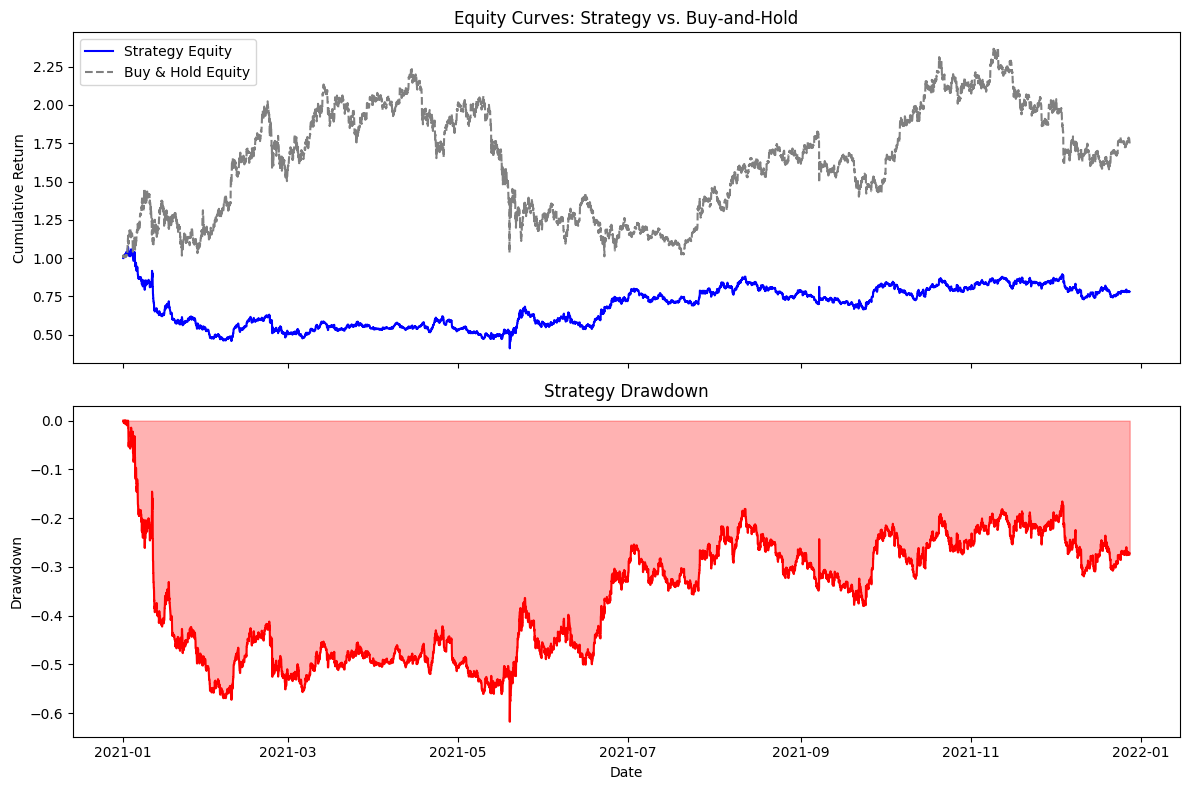

===== BACKTEST METRICS =====
Years                                   : 34.38
Total Return (Strategy)    : -21.94%
CAGR (Strategy)            : -0.0072
Volatility (Strategy)      : 0.1263
Sharpe (Strategy)          : -0.0568
Sortino (Strategy)         : -0.0591
Max Drawdown               : -0.6178
Avg Holding Period (bars)  : 2.99
Total Return (Buy & Hold)  : 74.88%
CAGR (Buy & Hold)          : 0.0164
Volatility (Buy & Hold)    : 0.1602
Sharpe (Buy & Hold)        : 0.1023


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_backtest(df):
    """
    df must be in ascending time order (row 0 is earliest).
    It must contain:
      • 'close'           (price at close of each bar)
      • 'y_hat_backtest'  (signal ∈ {+1, 0, -1} indicating long/flat/short for the NEXT bar)

    We compute:
      - bar‐to‐bar returns
      - apply each bar’s *prior* signal to the next bar’s return
      - build an equity curve
      - compute performance metrics and plots

    Returns (df_with_metrics, metrics_dict).
    """
    df = df.copy()  # do NOT call sort_index() if your index is mixed

    # 1) Compute simple returns: close[t] / close[t-1] - 1
    #    First bar’s return is set to 0 since there is no prior bar.
    df['ret'] = df['close'].pct_change().fillna(0)

    # 2) Shift the signal forward one bar so that
    #    the signal value at time t is the position we take *into* bar (t+1).
    #    If y_hat_backtest[t] = +1, we go long at t’s close, then capture ret[t+1].
    df['signal'] = df['y_hat_backtest'].shift(1).fillna(0)

    # 3) Strategy return: signal[t] * ret[t]
    #    If signal[t]= +1, we capture ret[t]
    #    If signal[t]= -1, we capture -ret[t] (short)
    #    If signal[t]=  0, we capture 0 (flat)
    df['strat_ret'] = df['signal'] * df['ret']

    # 4) Equity curve: compound (1 + strat_ret) from an initial capital of 1.0
    df['equity'] = (1 + df['strat_ret']).cumprod()

    # 5) Build a simple Buy‐and‐Hold (BnH) for comparison: compound (1 + ret)
    df['bnh_equity'] = (1 + df['ret']).cumprod()

    # 6) Drawdowns:
    df['rolling_max'] = df['equity'].cummax()
    df['drawdown']    = (df['equity'] - df['rolling_max']) / df['rolling_max']
    max_drawdown      = df['drawdown'].min()  # e.g. -0.25 means a 25% peak‐to‐valley drop

    # 7) Figure out annualization factor based on frequency:
    freq = pd.infer_freq(df.index)
    if freq is None or freq.startswith('D'):
        annual_factor = 252
    elif freq.startswith('H'):
        annual_factor = 252 * 24
    elif freq.startswith('T') or freq.startswith('min'):
        annual_factor = 252 * 24 * 60
    else:
        annual_factor = 252

    # 8) Performance metrics:
    #  8a) Total return = equity[-1] - 1
    total_return = df['equity'].iloc[-1] - 1
    n_years      = len(df) / annual_factor

    #  8b) CAGR
    cagr = df['equity'].iloc[-1] ** (1.0 / n_years) - 1

    #  8c) Annualized volatility of strategy returns
    ann_vol = df['strat_ret'].std() * np.sqrt(annual_factor)

    #  8d) Sharpe ratio (assume rf=0)
    sharpe = cagr / ann_vol if ann_vol != 0 else np.nan

    #  8e) Sortino ratio: only “downside” volatility (neg. returns)
    neg_ret_mask = df['strat_ret'] < 0
    if neg_ret_mask.any():
        downside_dev = df.loc[neg_ret_mask, 'strat_ret'].std() * np.sqrt(annual_factor)
    else:
        downside_dev = 0.0
    sortino = cagr / downside_dev if downside_dev != 0 else np.nan

    #  8f) Maximum drawdown already computed as max_drawdown

    #  8g) Average Holding Period (in bars):
    #      Count consecutive runs of nonzero `signal` and average their lengths.
    signal_arr = df['signal'].fillna(0).values
    hold_lengths = []
    current_len = 0
    for s in signal_arr:
        if s != 0:
            current_len += 1
        else:
            if current_len > 0:
                hold_lengths.append(current_len)
            current_len = 0
    if current_len > 0:
        hold_lengths.append(current_len)
    avg_holding = np.mean(hold_lengths) if hold_lengths else 0

    #  8h) Buy‐and‐Hold comparators
    total_return_bnh = df['bnh_equity'].iloc[-1] - 1
    cagr_bnh         = df['bnh_equity'].iloc[-1] ** (1.0 / n_years) - 1
    ann_vol_bnh      = df['ret'].std() * np.sqrt(annual_factor)
    sharpe_bnh       = cagr_bnh / ann_vol_bnh if ann_vol_bnh != 0 else np.nan

    # 9) Collect metrics into a dictionary
    metrics = {
        "CAGR_strategy":       cagr,
        "Volatility_strategy": ann_vol,
        "Sharpe_strategy":     sharpe,
        "Sortino_strategy":    sortino,
        "MaxDrawdown":         max_drawdown,
        "AvgHoldingBars":      avg_holding,
        "TotalReturn_strategy": total_return,
        "CAGR_BnH":            cagr_bnh,
        "Volatility_BnH":      ann_vol_bnh,
        "Sharpe_BnH":          sharpe_bnh,
        "TotalReturn_BnH":     total_return_bnh,
        "Years":               n_years
    }

    # 10) Plot the equity curves and drawdown
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # 10a) Equity curves
    ax1.plot(df.index, df['equity'], label="Strategy Equity", color="blue")
    ax1.plot(df.index, df['bnh_equity'], label="Buy & Hold Equity", color="gray", linestyle="--")
    ax1.set_ylabel("Cumulative Return")
    ax1.legend(loc="upper left")
    ax1.set_title("Equity Curves: Strategy vs. Buy‐and‐Hold")

    # 10b) Drawdown plot
    ax2.plot(df.index, df['drawdown'], color="red")
    ax2.fill_between(df.index, df['drawdown'], 0, color="red", alpha=0.3)
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Date")
    ax2.set_title("Strategy Drawdown")
    plt.tight_layout()
    plt.show()

    # 11) Print metrics in a neat format
    print("===== BACKTEST METRICS =====")
    print(f"Years                                   : {n_years:.2f}")
    print(f"Total Return (Strategy)    : {total_return:.2%}")
    print(f"CAGR (Strategy)            : {cagr:.4f}")
    print(f"Volatility (Strategy)      : {ann_vol:.4f}")
    print(f"Sharpe (Strategy)          : {sharpe:.4f}")
    print(f"Sortino (Strategy)         : {sortino:.4f}")
    print(f"Max Drawdown               : {max_drawdown:.4f}")
    print(f"Avg Holding Period (bars)  : {avg_holding:.2f}")
    print(f"Total Return (Buy & Hold)  : {total_return_bnh:.2%}")
    print(f"CAGR (Buy & Hold)          : {cagr_bnh:.4f}")
    print(f"Volatility (Buy & Hold)    : {ann_vol_bnh:.4f}")
    print(f"Sharpe (Buy & Hold)        : {sharpe_bnh:.4f}")
    print("=" * 40)

    return df, metrics

# ───────────────────────────────────────────────────────────────────────────────
# USAGE EXAMPLE:
# ───────────────────────────────────────────────────────────────────────────────

# Suppose you have already built `df_backtest`, which:
#   • Is indexed by datetime (hourly or daily)
#   • Contains columns "close" and "y_hat_backtest" (values +1, 0, −1).
#
# First ensure there are no NaN signals:
df_backtest['y_hat_backtest'] = df_backtest['y_hat_backtest'].fillna(0)

# Then call:
df_with_metrics, backtest_metrics = run_backtest(df_backtest)

# The returned DataFrame `df_with_metrics` now has extra columns:
#     ['ret', 'signal', 'strat_ret', 'equity', 'bnh_equity', 'rolling_max', 'drawdown']
# And `backtest_metrics` is a dict containing your numeric summary (CAGR, Sharpe, etc.).


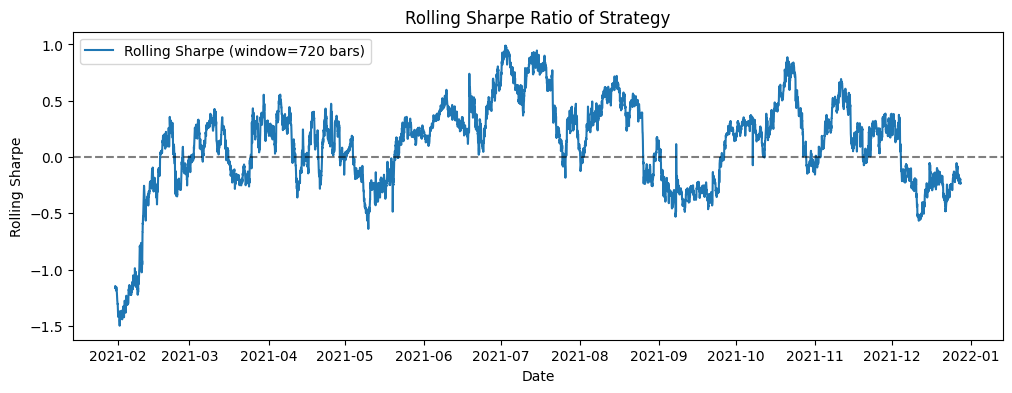

In [ ]:
# Choose a rolling window (in bars).
# If data is hourly, 24 × 30 = 720 bars ≈ one calendar month.
rolling_window_bars = 720

# Compute rolling mean and rolling std of strat_ret
rolling_mean      = df_with_metrics['strat_ret'].rolling(window=rolling_window_bars).mean()
rolling_std       = df_with_metrics['strat_ret'].rolling(window=rolling_window_bars).std()

# Annualize: sqrt(annual_factor) * rolling_std. Use the same annual_factor as before.
freq = pd.infer_freq(df_with_metrics.index)
if freq is None or freq.startswith('D'):
    annual_factor = 252
elif freq.startswith('H'):
    annual_factor = 252 * 24
elif freq.startswith('T') or freq.startswith('min'):
    annual_factor = 252 * 24 * 60
else:
    annual_factor = 252

rolling_sharpe = (rolling_mean * annual_factor) / (rolling_std * np.sqrt(annual_factor))

plt.figure(figsize=(12, 4))
plt.plot(df_with_metrics.index, rolling_sharpe, label=f"Rolling Sharpe (window={rolling_window_bars} bars)")
plt.axhline(0, color='black', alpha=0.5, linestyle='--')
plt.ylabel("Rolling Sharpe")
plt.xlabel("Date")
plt.title("Rolling Sharpe Ratio of Strategy")
plt.legend()
plt.show()


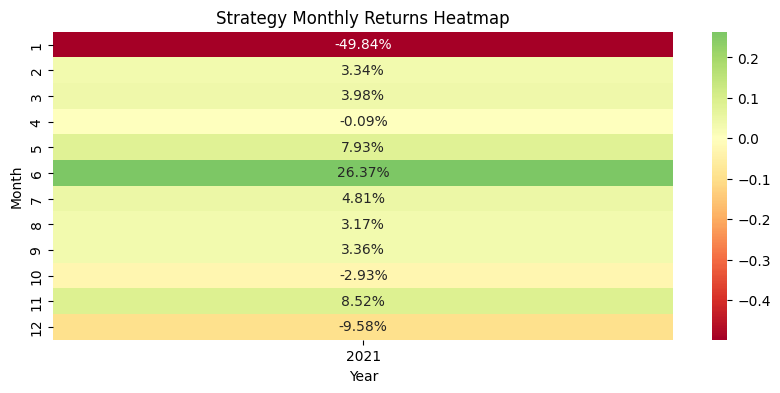

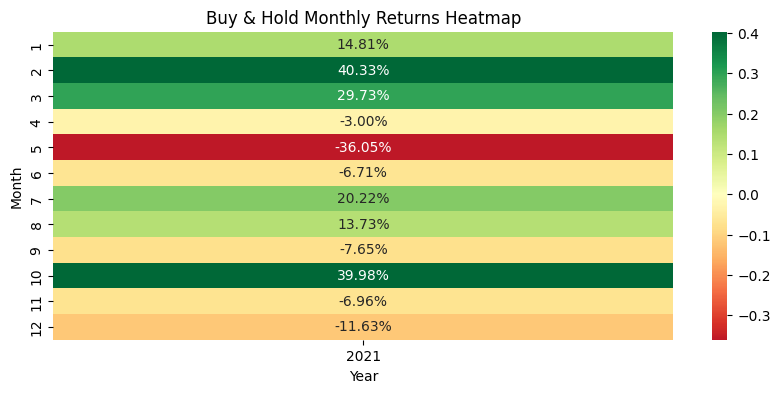

In [ ]:
# Compute calendar‐month returns for strategy and BnH
df = df_with_metrics.copy()
df['year']  = df.index.year
df['month'] = df.index.month

# For each (year, month), take the last equity value and divide by the first equity value
# within that calendar‐month to get the month’s return.
monthly = df.groupby(['year', 'month']).agg({
    'equity': 'last',
    'bnh_equity': 'last'
})
# We also need the first equity for each month
monthly_first = df.groupby(['year', 'month']).agg({
    'equity': 'first',
    'bnh_equity': 'first'
}).rename(columns={'equity':'equity_first','bnh_equity':'bnh_first'})

monthly = monthly.join(monthly_first)
monthly['strat_month_return'] = monthly['equity'] / monthly['equity_first'] - 1
monthly['bnh_month_return']   = monthly['bnh_equity'] / monthly['bnh_first'] - 1

# Pivot to a year×month DataFrame for heatmap
strat_ret_pivot = monthly['strat_month_return'].unstack(level=0)  # index=month, columns=year
bnh_ret_pivot   = monthly['bnh_month_return'].unstack(level=0)

import seaborn as sns

plt.figure(figsize=(10, 4))
sns.heatmap(strat_ret_pivot, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Strategy Monthly Returns Heatmap")
plt.ylabel("Month")
plt.xlabel("Year")
plt.show()

plt.figure(figsize=(10, 4))
sns.heatmap(bnh_ret_pivot, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Buy & Hold Monthly Returns Heatmap")
plt.ylabel("Month")
plt.xlabel("Year")
plt.show()


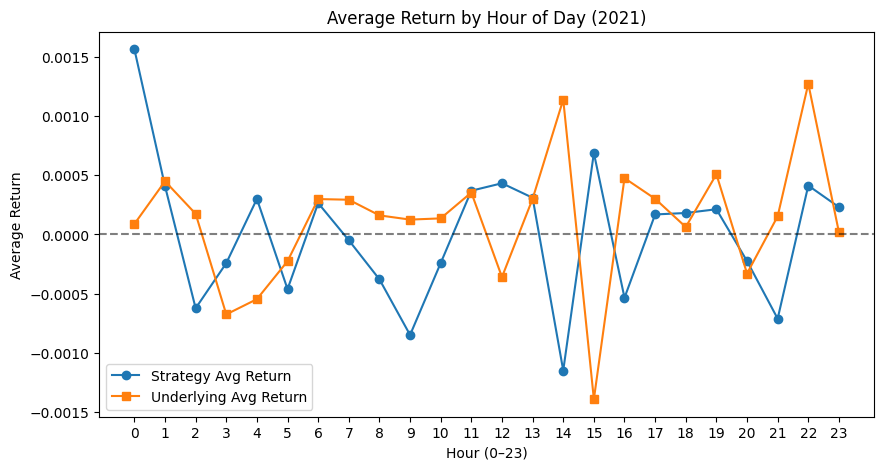

In [ ]:
# Add an 'hour' column
df = df_with_metrics.copy()
df['hour'] = df.index.hour

# For each hour (0–23), average the strategy return and BnH return
hourly_avg = df.groupby('hour').agg({
    'strat_ret': 'mean',
    'ret': 'mean'
})

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg['strat_ret'], marker='o', label="Strategy Avg Return")
plt.plot(hourly_avg.index, hourly_avg['ret'],   marker='s', label="Underlying Avg Return")
plt.axhline(0, color='black', alpha=0.5, linestyle='--')
plt.title("Average Return by Hour of Day (2021)")
plt.xlabel("Hour (0–23)")
plt.ylabel("Average Return")
plt.xticks(range(0, 24))
plt.legend()
plt.show()


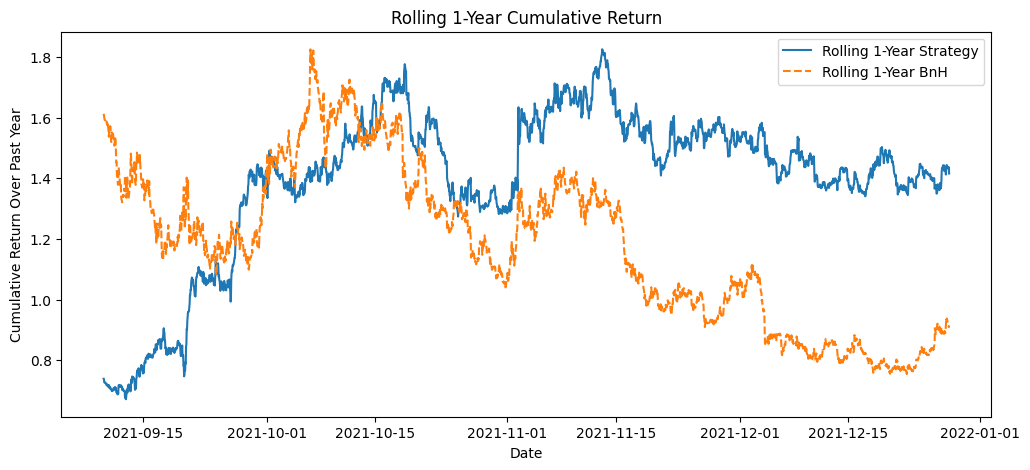

In [ ]:
# Rolling 30-day cumulative return: for an hourly series that is 30×24 = 720 bars
rolling_window = 252 * 24  # e.g. a full “annual” in hour units, or choose 720 for roughly 30 days.

df = df_with_metrics.copy()
df['rolling_strat_equity'] = df['strat_ret'].add(1).rolling(window=rolling_window).apply(np.prod, raw=True)
df['rolling_bnh_equity']   = df['ret'].add(1).rolling(window=rolling_window).apply(np.prod, raw=True)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['rolling_strat_equity'], label="Rolling 1‐Year Strategy")
plt.plot(df.index, df['rolling_bnh_equity'],   label="Rolling 1‐Year BnH", linestyle='--')
plt.title("Rolling 1-Year Cumulative Return")
plt.ylabel("Cumulative Return Over Past Year")
plt.xlabel("Date")
plt.legend()
plt.show()


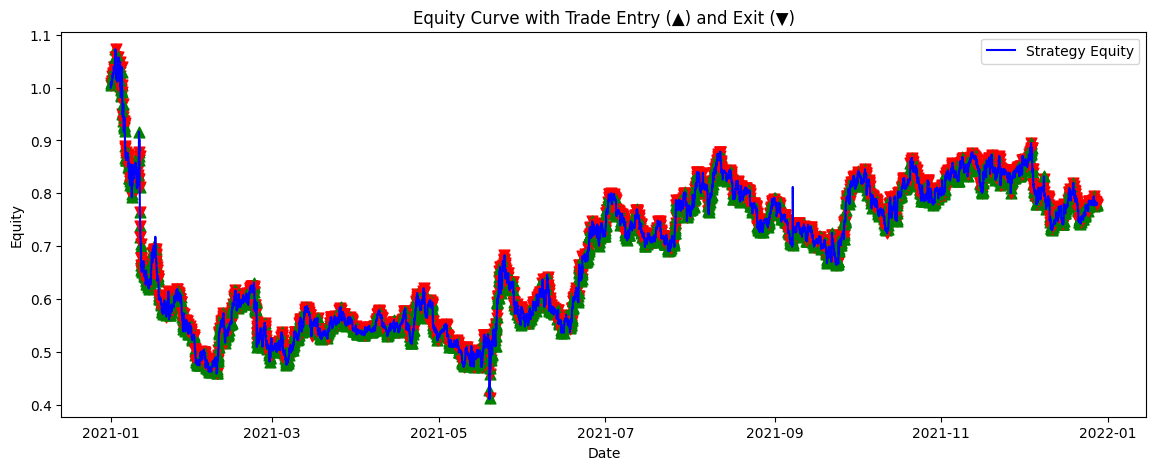

In [ ]:
# We already built `trades_df` above. If not, re‐compute so that trades_df has entry_time and exit_time columns.

# Plot the equity curve
plt.figure(figsize=(14, 5))
plt.plot(df_with_metrics.index, df_with_metrics['equity'], color='blue', label='Strategy Equity')

# Overlay markers:
for _, trade in trades_df.iterrows():
    entry = trade['entry_time']
    exit  = trade['exit_time']
    # Get equity at those times
    equity_entry = df_with_metrics.loc[entry, 'equity']
    equity_exit  = df_with_metrics.loc[exit,  'equity']
    # Plot ▲ at entry, ▼ at exit
    plt.scatter(entry, equity_entry, marker='^', color='green', s=60)
    plt.scatter(exit,  equity_exit,  marker='v', color='red',   s=60)

plt.title("Equity Curve with Trade Entry (▲) and Exit (▼)")
plt.ylabel("Equity")
plt.xlabel("Date")
plt.legend()
plt.show()


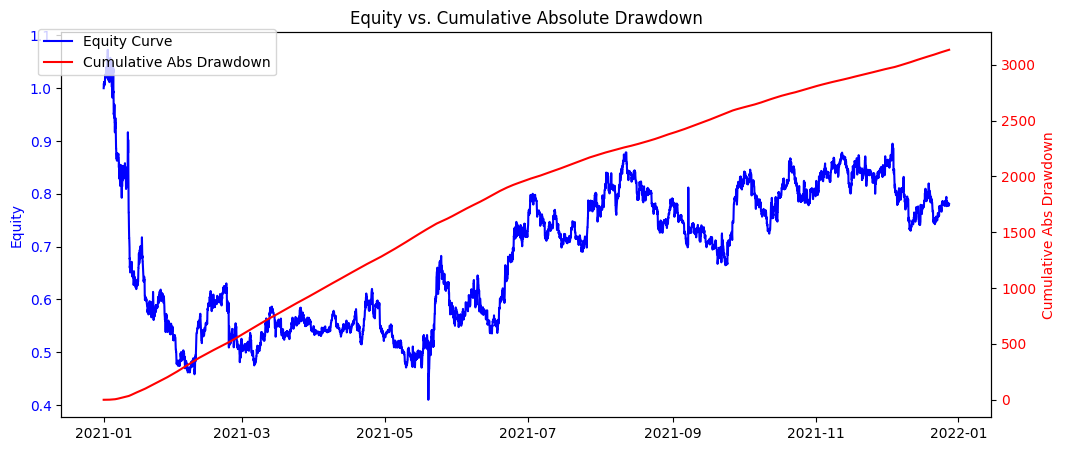

In [ ]:
df = df_with_metrics.copy()

# Compute absolute drawdown whenever drawdown < 0 (underwater)
df['abs_dd'] = df['drawdown'].clip(upper=0).abs()

# Cumulative sum of absolute drawdowns
df['cad'] = df['abs_dd'].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df.index, df['equity'], color='blue', label='Equity Curve')
ax1.set_ylabel("Equity", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['cad'], color='red', label='Cumulative Abs Drawdown')
ax2.set_ylabel("Cumulative Abs Drawdown", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.title("Equity vs. Cumulative Absolute Drawdown")
plt.show()


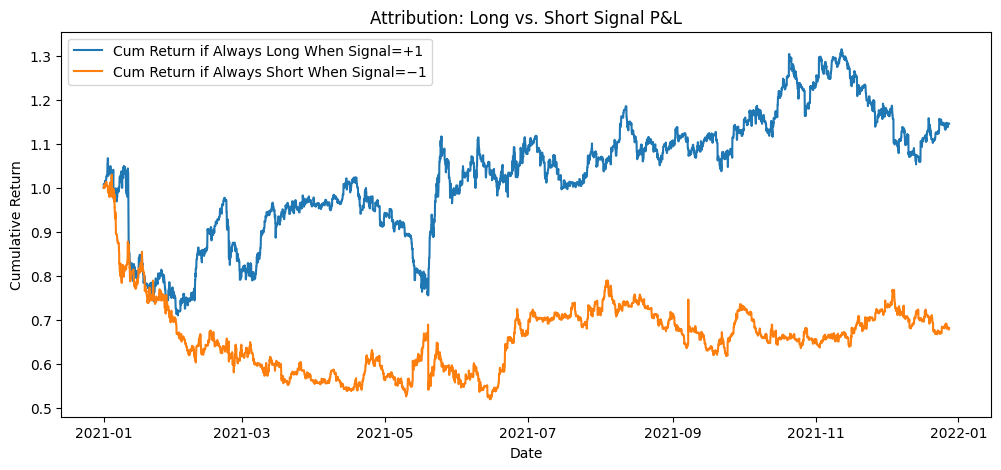

In [ ]:
df = df_with_metrics.copy()

# Separate returns based on the prior bar’s signal
long_mask  = df['signal'] == 1
short_mask = df['signal'] == -1

long_returns  = df.loc[long_mask,  'ret']
short_returns = df.loc[short_mask, 'ret']

# Cumulative returns of being long-only
cum_long = (1 + long_returns).cumprod().reindex(df.index, method='ffill').fillna(1)
# Cumulative returns of being short-only
cum_short = (1 - short_returns).cumprod().reindex(df.index, method='ffill').fillna(1)

plt.figure(figsize=(12, 5))
plt.plot(df.index, cum_long,  label="Cum Return if Always Long When Signal=+1")
plt.plot(df.index, cum_short, label="Cum Return if Always Short When Signal=−1")
plt.title("Attribution: Long vs. Short Signal P&L")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.show()


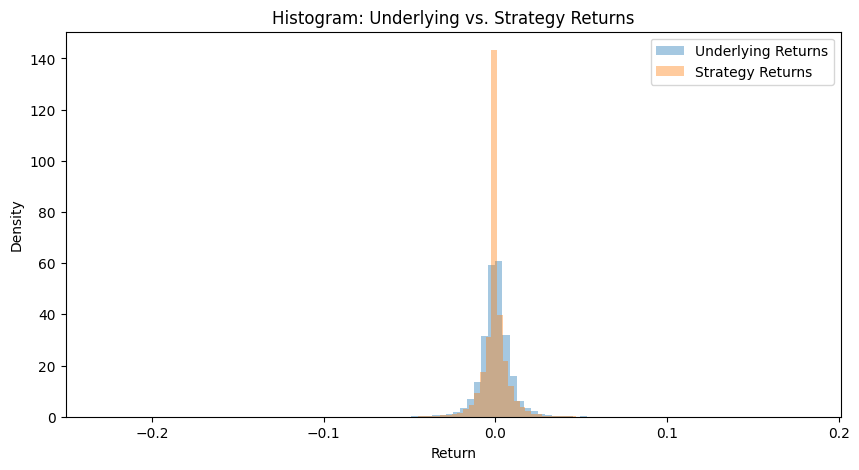

In [ ]:
import matplotlib.pyplot as plt

# 1) Extract arrays (drop the very first bar’s zero‐return if you like)
strategy_returns = df_with_metrics['strat_ret'].values
underlying_returns = df_with_metrics['ret'].values

plt.figure(figsize=(10, 5))
plt.hist(underlying_returns, bins=100, alpha=0.4, label='Underlying Returns', density=True)
plt.hist(strategy_returns, bins=100, alpha=0.4, label='Strategy Returns', density=True)
plt.title("Histogram: Underlying vs. Strategy Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.show()
